In [55]:
# Initialize Otter
import otter
grader = otter.Notebook("covid_part2.ipynb")

# Final Project: COVID-19 Dataset
## Exploring COVID-19 Data through Modeling
## Due Date: Thursday, December 13th, 11:59 PM
## Collaboration Policy

Data science is a collaborative activity. While you may talk with other groups about
the project, we ask that you **write your solutions individually**. If you do
discuss the assignments with others outside of your group please **include their names** at the top
of your notebook.


## This Assignment

In this final project, we will investigate COVID-19 data over the past year. This data contains information about COVID-19 case counts, mortalities, vaccination rates, and various other metadata that can assist in modeling various aspects of COVID-19.

Through this final project, you will demonstrate your experience with:
* Data cleaning and EDA using Pandas
* Unsupervised and supervised learning techniques
* Visualization


## Goal

Model and analyze the temporal evolution of COVID-19 mortalities or cases using one unsupervised and one supervised technique of your choice. Interpret your models' results through visualizations, and draw insightful conclusions about the modeling of COVID-19 data.

Recall that we studied linear and logistic regression, decision trees, random forests as part of supervised learning (with labels) and clustering, PCA as part of unsupervised learning (without labels). You are free to use any methods that you find suitable to answer the problem at hand.

In [56]:
# Run this cell to set up your notebook
import numpy as np
from geopy import *
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import *
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy.stats import pearsonr
import re

cases = pd.read_csv('data/time_series_covid19_confirmed_US.csv') # https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv
vaccinations= pd.read_csv('data/people_vaccinated_us_timeline.csv') # https://raw.githubusercontent.com/govex/COVID-19/master/data_tables/vaccine_data/us_data/time_series/people_vaccinated_us_timeline.csv
counties = pd.read_csv('data/co-est2020.csv', encoding='latin-1') # https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/counties/totals/co-est2020.csv
mask_use = pd.read_csv('data/mask-use-by-county.csv') # https://github.com/nytimes/covid-19-data/blob/master/mask-use/mask-use-by-county.csv

<br/><br/><br/>

---

<br/><br/><br/>

## Data Cleaning (Again!)

For this section, please copy over the appropriate answers from your previous notebook submission.

### Part 1: Question 1a

Impute the null values in *all* the datasets with zero values or empty strings where appropriate.

<!--
BEGIN QUESTION
name: q1a
points: 0
-->

In [57]:
cases.fillna(0, inplace=True)
vaccinations.fillna(0, inplace=True)
counties.fillna(0, inplace=True)
mask_use.fillna(0, inplace=True)

In [58]:
grader.check("q1a")

q1a results: All test cases passed!

### Part 1: Question 1d

Generate a valid FIPS code for the `counties` table.

*Hint*: Refer to [this](https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt) guide on FIPS codes.

<!--
BEGIN QUESTION
name: q1d
points: 0
-->

In [59]:
counties['FIPS'] = counties['STATE'].map("{:02}".format) + counties['COUNTY'].map("{:03}".format)
counties['FIPS'] = counties['FIPS'].astype(float)
counties.head()

SUMLEV  REGION  DIVISION  STATE  COUNTY   STNAME         CTYNAME  \
0      40       3         6      1       0  Alabama         Alabama   
1      50       3         6      1       1  Alabama  Autauga County   
2      50       3         6      1       3  Alabama  Baldwin County   
3      50       3         6      1       5  Alabama  Barbour County   
4      50       3         6      1       7  Alabama     Bibb County   

  CENSUS2010POP  ESTIMATESBASE2010  POPESTIMATE2010  ...  POPESTIMATE2013  \
0       4779736            4780118          4785514  ...          4831586   
1         54571              54582            54761  ...            54747   
2        182265             182263           183121  ...           194978   
3         27457              27454            27325  ...            26946   
4         22915              22904            22858  ...            22510   

   POPESTIMATE2014  POPESTIMATE2015  POPESTIMATE2016  POPESTIMATE2017  \
0          4843737          4854803          4866824          4877989   
1            54922            54903            55302            55448   
2           199306           203101           207787           212737   
3            26768            26300            25828            25169   
4            22541            22553            22590            22532   

   POPESTIMATE2018  POPESTIMATE2019  POPESTIMATE042020  POPESTIMATE2020  \
0          4891628          4907965            4920706          4921532   
1            55533            55769              56130            56145   
2           218071           223565             227989           229287   
3            24887            24657              24652            24589   
4            22300            22313              22199            22136   

     FIPS  
0  1000.0  
1  1001.0  
2  1003.0  
3  1005.0  
4  1007.0  

[5 rows x 22 columns]

In [60]:
grader.check("q1d")

q1d results: All test cases passed!

### Part 1: Question 1e

Merge the `counties`, `cases`, and `mask_use` tables on an appropriate primary key to generate county-wise data.

<!--
BEGIN QUESTION
name: q1e
points: 0
-->

In [61]:
mask_use['COUNTYFP'] = mask_use['COUNTYFP'].astype(float)
county_data = cases.merge(counties, how = "inner", on = "FIPS").merge(mask_use, how = "inner", left_on="FIPS", right_on="COUNTYFP")
county_data

UID iso2 iso3  code3     FIPS      Admin2 Province_State  \
0     84001001   US  USA    840   1001.0     Autauga        Alabama   
1     84001003   US  USA    840   1003.0     Baldwin        Alabama   
2     84001005   US  USA    840   1005.0     Barbour        Alabama   
3     84001007   US  USA    840   1007.0        Bibb        Alabama   
4     84001009   US  USA    840   1009.0      Blount        Alabama   
...        ...  ...  ...    ...      ...         ...            ...   
3136  84056037   US  USA    840  56037.0  Sweetwater        Wyoming   
3137  84056039   US  USA    840  56039.0       Teton        Wyoming   
3138  84056041   US  USA    840  56041.0       Uinta        Wyoming   
3139  84056043   US  USA    840  56043.0    Washakie        Wyoming   
3140  84056045   US  USA    840  56045.0      Weston        Wyoming   

     Country_Region        Lat       Long_  ... POPESTIMATE2018  \
0                US  32.539527  -86.644082  ...           55533   
1                US  30.727750  -87.722071  ...          218071   
2                US  31.868263  -85.387129  ...           24887   
3                US  32.996421  -87.125115  ...           22300   
4                US  33.982109  -86.567906  ...           57770   
...             ...        ...         ...  ...             ...   
3136             US  41.659439 -108.882788  ...           43188   
3137             US  43.935225 -110.589080  ...           23261   
3138             US  41.287818 -110.547578  ...           20299   
3139             US  43.904516 -107.680187  ...            7886   
3140             US  43.839612 -104.567488  ...            6895   

      POPESTIMATE2019  POPESTIMATE042020  POPESTIMATE2020  COUNTYFP  NEVER  \
0               55769              56130            56145    1001.0  0.053   
1              223565             227989           229287    1003.0  0.083   
2               24657              24652            24589    1005.0  0.067   
3               22313              22199            22136    1007.0  0.020   
4               57840              57932            57879    1009.0  0.053   
...               ...                ...              ...       ...    ...   
3136            42917              42717            42673   56037.0  0.061   
3137            23385              23453            23497   56039.0  0.095   
3138            20196              20169            20215   56041.0  0.098   
3139             7824               7756             7760   56043.0  0.204   
3140             6880               6752             6743   56045.0  0.142   

      RARELY  SOMETIMES  FREQUENTLY  ALWAYS  
0      0.074      0.134       0.295   0.444  
1      0.059      0.098       0.323   0.436  
2      0.121      0.120       0.201   0.491  
3      0.034      0.096       0.278   0.572  
4      0.114      0.180       0.194   0.459  
...      ...        ...         ...     ...  
3136   0.295      0.230       0.146   0.268  
3137   0.157      0.160       0.247   0.340  
3138   0.278      0.154       0.207   0.264  
3139   0.155      0.069       0.285   0.287  
3140   0.129      0.148       0.207   0.374  

[3141 rows x 638 columns]

In [62]:
grader.check("q1e")

q1e results: All test cases passed!

<br/><br/><br/>

---

<br/><br/><br/>

## Question 5: Guided Supervised Modeling

This section will guide you through creating a supervised learning framework that will predict the number of COVID-19 cases per capita given various COVID-19 safety protocols that have been implemented. Then, we will investigate the bias, variance, and observational noise of this framework.

Note that any answer responses without the appropriate work (i.e. code or math) will be subject to additional review and will not receive any credit.

<!-- BEGIN QUESTION -->

### Question 5a

We will use county-wise mask usage data to predict the number of COVID-19 cases on September 12th, 2021. Create a visualization that shows the pairwise correlation between each combination of column in the mask usage data and the number of COVID-19 cases.

*Hint*: You should be plotting 36 correlations.
<!--
BEGIN QUESTION
name: q5a
points: 3
manual: True
-->

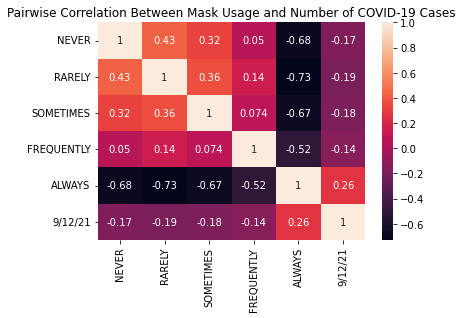

In [63]:
#county_data["case_capita_9/12/21"] = county_data[["9/12/21"]] / county_data[["POPESTIMATE2020"]].to_numpy()
q5a_df = county_data[["NEVER", "RARELY", "SOMETIMES", "FREQUENTLY", "ALWAYS", "9/12/21"]]
sns.heatmap(q5a_df.corr(), annot=True)
plt.title("Pairwise Correlation Between Mask Usage and Number of COVID-19 Cases");

<!-- END QUESTION -->

### Question 5b

Train a linear regression model to predict the number of COVID-19 cases using county-wise mask usage data for September 12, 2021. Evaluate your model's RMSE on a held-out validation set with 33% of the county-wise data. When possible, make sure to set `random_state = 42` when splitting your data into training and test sets.
<!--
BEGIN QUESTION
name: q5b
points: 5
-->

In [64]:
X_q5b = q5a_df.drop(columns = {"9/12/21"})
y_q5b = pd.Series(q5a_df["9/12/21"]) #actual COVID cases

# Make sure to set random_state = 42 and test_size = 0.33!
X_q5b_train, X_q5b_test, y_q5b_train, y_q5b_test = train_test_split(X_q5b, y_q5b, test_size=0.33, random_state = 42)

linear_model = LinearRegression()
linear_model.fit(X = X_q5b_train, y = y_q5b_train)
print(X_q5b_train)
#define rmse function
def rmse(actual_y, predicted_y):
    return np.sqrt(np.mean((actual_y - predicted_y)**2))

train_rmse_cases = rmse(y_q5b_train, linear_model.predict(X_q5b_train)) 
test_rmse_cases = rmse(y_q5b_test, linear_model.predict(X_q5b_test))

train_rmse_cases, test_rmse_cases

      NEVER  RARELY  SOMETIMES  FREQUENTLY  ALWAYS
620   0.011   0.082      0.167       0.172   0.567
1894  0.096   0.010      0.212       0.173   0.509
553   0.151   0.120      0.102       0.243   0.385
2793  0.028   0.032      0.094       0.202   0.644
1554  0.156   0.121      0.140       0.211   0.373
...     ...     ...        ...         ...     ...
3092  0.071   0.056      0.198       0.233   0.443
1095  0.096   0.138      0.195       0.206   0.365
1130  0.067   0.053      0.095       0.366   0.420
1294  0.061   0.117      0.106       0.259   0.458
860   0.088   0.053      0.068       0.310   0.481

[2104 rows x 5 columns]


(28745.116729283855, 61671.75722098981)

In [65]:
grader.check("q5b")

q5b results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 5c

Explain potential reasons the test set RMSE is much higher as compared to the training set RMSE.
<!--
BEGIN QUESTION
name: q5c
points: 3
manual: True
-->

_The usual reason is that our test data is very different from the training set since the population in different counties is different, so for counties with a larger number of population, it's natural to have more cases but that doesn't represent mask uasge is less effective in this contuny. We should predict the normalized number of COVID-19 cases._

<!-- END QUESTION -->

### Question 5d

Instead of predicting the number of COVID-19 cases, redo part (b) by predicting the number of cases per capita. Report the model's RMSE on the training and validation set.

Comment on the relationship between the training and test RMSE by predicting the number of cases per capita instead of the total number of cases.
<!--
BEGIN QUESTION
name: q5d
points: 3
-->

In [66]:
q5d_df = q5a_df.copy().drop(columns = {"9/12/21"})
q5d_df["9/12/21_Cases_Per_Capita"] = q5a_df["9/12/21"] / county_data["POPESTIMATE2020"]


X_q5d = q5d_df.drop(columns = {"9/12/21_Cases_Per_Capita"})
y_q5d = pd.Series(q5d_df["9/12/21_Cases_Per_Capita"]) 
X_q5d_train, X_q5d_test, y_q5d_train, y_q5d_test = train_test_split(X_q5d, y_q5d, test_size=0.33, random_state = 42)

linear_model_2 = LinearRegression()
linear_model_2.fit(X = X_q5d, y = y_q5d)

train_rmse_cpc = rmse(y_q5d_train, linear_model_2.predict(X_q5d_train)) 
test_rmse_cpc = rmse(y_q5d_test, linear_model_2.predict(X_q5d_test))


train_rmse_cpc, test_rmse_cpc

(0.03553147592552991, 0.03791719933949232)

In [67]:
grader.check("q5d")

q5d results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 5e

Visualize the model outputs from part (d) by plotting the predictions $\hat{y}$ versus the observations $y$. Comment on what the plot indicates about our linear model as a comment in the code cell.

<!--
BEGIN QUESTION
name: q5e
points: 3
manual: True
-->

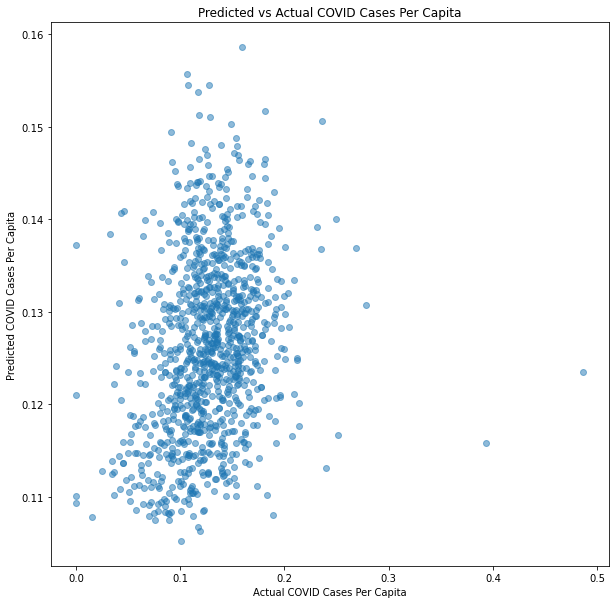

In [68]:
Y_pred_q5d = linear_model_2.predict(X_q5d_test)
plt.figure(figsize=(10, 10))
plt.scatter(y_q5d_test, Y_pred_q5d, alpha=0.5)
plt.xlabel("Actual COVID Cases Per Capita")
plt.ylabel("Predicted COVID Cases Per Capita")
plt.title("Predicted vs Actual COVID Cases Per Capita");

<!-- END QUESTION -->

### Question 5f

We will investigate the bias and variance of this improved model on the test set using the bias-variance decomposition to formalize the behaviour of our model. To generate an empirical estimate of the errors and the parameters in the bias-variance decomposition, train 1000 bootstrapped models on the training dataset from part (d).

<!--
BEGIN QUESTION
name: q5f
points: 5
-->

In [69]:
q5f_df = X_q5d_train.copy()
q5f_df["9/12/21_Cases_Per_Capita"] = y_q5d_train

models = []
for i in range(1000):
    #Sample randomly
    sample_size = len(q5d_df)
    sample_df = q5f_df.sample(n = sample_size, replace = True) #how large should sample size be?
    
    X_q5f = sample_df.drop(columns = {"9/12/21_Cases_Per_Capita"})
    y_q5f = pd.Series(sample_df["9/12/21_Cases_Per_Capita"]) 

    #train on test set??
    m = LinearRegression()
    #m.fit(X = X_q5f_test, y = y_q5f_test)
    m.fit(X = X_q5f, y = y_q5f)
    
    models.append(m)
    

In [70]:
grader.check("q5f")

q5f results: All test cases passed!

### Question 5g

To investigate the variance in our test predictions, we sample a particular test point $(x_i, y_i)$ such that $i = 100$. In other words, we will use the 100th point in the test set from part (d), `(X_q5d_test.iloc[100], y_q5d_test.iloc[100])` as the testing point.

Generate predictions and square errors for this test point for all 1000 models, and calculate the *proportion* of the *expected* square error that is captured by the model prediction variance. In other words, we wish to estimate the following quantity:

$$
\frac{\mathrm{Var}(f_\theta(x_i))}{\mathrm{E}_\theta[(y_i - f_\theta(x_i))^2]}
$$

*Hint*: Refer to the bias-variance decomposition from lecture.
<!--
BEGIN QUESTION
name: q5g
points: 5
-->

In [71]:
X_testp, y_testp = np.array(X_q5d_test.iloc[100]).reshape(1,-1), np.array(y_q5d_test.iloc[100]).reshape(1,-1)
model_var = []
model_se = []
y_pred = []
def se(y,yhat): 
    return (y-yhat)**2

for m in models:
    y_pred5g = m.predict(X_testp)
    y_pred.append(y_pred5g)
    model_se.append(se(y_testp, y_pred5g))
    model_var.append(y_pred5g)

bias = np.mean(model_se)
variance = np.var(model_var)   
prop_var = variance/bias

In [72]:
grader.check("q5g")

q5g results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 5h

Using the bias-variance decomposition, comment on how much the variance of the model contributes to the error on the sample point above. We will extend this scenario to analyze the noise term in the bias-variance decomposition, specifically with regards to this COVID-19 dataset. Consider the following:

i) Assuming no observational noise (i.e. $\epsilon = 0$), what is the *magnitude* of the empirical model bias on this sample point?

ii) Clearly, there is a non-trivial amount of observational noise with COVID-19 case data simply due to how testing works and occurs. Please take a look at [this article](https://fivethirtyeight.com/features/coronavirus-case-counts-are-meaningless/) for more information. Given this infomation, explain the issues with the assumptions and result in 5h(i).

iii) Recall that we typically assume $y = g(x) + \epsilon$, where $\epsilon \sim \mathcal{N}(\mu, \sigma)$. In the theoretical setting for bias-variance, we have assumed $\mu = 0, \sigma > 0$. In this practical setting, analyze and determine how $\epsilon$ could be modeled (as a normal distribution, but you may also consider how it could be modeled as another distribution). Are there any immediate issues with the assumptions we have made in the theoretical setting where $\mu = 0, \sigma > 0$? What conditions on $\mu, \sigma$ could be more appropriate and why?

iv) Does the standard bias-variance decomposition presented in lecture hold given $\epsilon$ being normally distributed according to your answer in part (iii)? If so, please explain why. If not, explain why it does not hold and if possible, how to modify the bias-variance decomposition to make it hold (i.e. perhaps there is an additional noise term $E[\epsilon^3]$). 

*Hint*: Try to express $y = g(x) + \epsilon$ by adding and subtracting a certain quantity.

v) Intuitively, is it possible to minimize the true model bias to 0 given your $\epsilon$ formulation in part (iii)? Why or why not? Justify your answer using part (iv) if possible.

vi) Consider the infinite sample case where an oracle grants you as many samples as requested, and answer the same question in part (v). Is it possible to minimize the true model bias to 0 given your $\epsilon$ formulation in part (iii)? Conclude with an analysis of what our modeling task can approximate using $X\theta \approx y$ in the finite and infinite sample case.

<!--
BEGIN QUESTION
name: q5h
points: 24
manual: True
-->

Answer for 5h is here:



i) bias = E(Y(x)) - g(x) = -0.04042883



ii) The bias is smaller than 0 which means our model tends to underestimate at x. There is noise with case data due to how testing works and occurs. First, the case count can be small because there is not enough testing. Second, people who actually have COVID-19 test negative for it. Third, some people with mild symptoms won't get tests. Those are all possible conditions that make us underestimate real cases.



iii)  $\epsilon=y-g(x)$   We can calculate the  $\epsilon$ with predicted y and groundtruth and visualize the distribution of $\epsilon$. Due to bias in our data and sampling method, the $\mu$ might not be 0,since we have both chance errors and bias. According to the distribution of $\epsilon$ in the following figure, we can see that the $\epsilon$ can be modeled as a normal distribution but its $\mu$ is about -0.04 and $\sigma$  is about 1.5e-06. According to our analysis, a good new condition is that $\mu$ < 0,  $\mu$ > $\sigma$.




 

-0.04042348032361651


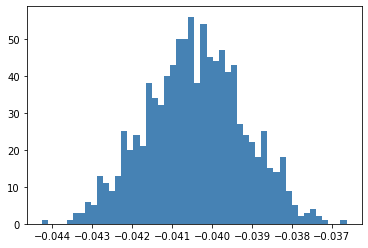

In [73]:
#question iii)
ep = y_pred - y_testp
mu_up = np.mean(ep)
mu_var= np.var(ep)
plt.hist(ep, bins=50, color='steelblue')
print(mu_up)

iv）No. Since our new distribution of $\epsilon$ is not 0 expectiation normal distribution and  the new y is like this: $y = g(x) + \delta + \epsilon$, where $\delta$ is a bias constant. Then the prediction error can be decomposed into 4 pieces: $Y - \hat{Y}(x) = \epsilon + \delta + (g(x) - E(\hat{Y}(x))) + (E(\hat{Y}(x)) - \hat{Y}(x))$. Then $E((Y-\hat{Y}(x)){^2}) = E(\epsilon^{2})  + (\delta + g(x) - E(\hat{Y}(x)))^{2} + E((E(\hat{Y}(x)) - \hat{Y}(x))^{2})$

v) Intuitively, I think it is impossible to minimize the true model bias to 0 if only when we have $\delta + g(x)-E(\hat{Y}(x))=0$, the model bias is zero but it's impossible to get $g(x)-E(\hat{Y}(x))$ in advance.

vi) With infinite samples, we can minimize our bias to zero since our model can completely approch g(x), but with finite cases, we are not able to make such a perfect and precise convergence.

<!-- END QUESTION -->

### Question 5i

Using the bias-variance decomposition for each test point, calculate the average variance and average test mean-square error across the entire test set from part (d). In other words, estimate the following quantities:

$$
\frac{1}{n} \sum_i \mathrm{Var}(f_\theta(x_i))
$$

and

$$
\frac{1}{n} \sum_i \mathrm{E}_\theta[(y_i - f_\theta(x_i))^2]
$$

<!--
BEGIN QUESTION
name: q5i
points: 5
manual: False
-->

In [74]:
var_dps = []
mse_dps = []
model_preds = []
for m in models:
    model_preds.append(m.predict(X_q5d_test))
                       
for i in range(len(X_q5d_test)):
    preds = []
    for t in range(len(models)):
        preds.append(model_preds[t][i])
    var = np.var(preds)                   
    mse = sum((y_q5d_test.iloc[i] - preds)**2)/len(preds)
    var_dps.append(var)
    mse_dps.append(mse)

avg_var, avg_mse = np.mean(var_dps), np.mean(mse_dps)

avg_var, avg_mse

(2.6332885757547453e-06, 0.0014431181913354)

In [75]:
grader.check("q5i")

q5i results: All test cases passed!

<!-- BEGIN QUESTION -->

## Question 5j

Propose a solution to reducing the mean square error using the insights gained from the bias-variance decomposition above. What are the values of the quantities that have we estimated and what can be concluded about the remaining quantities? Please show all work that informs your analysis.

Assume that the standard bias-variance decomposition used in lecture can be applied here.
<!--
BEGIN QUESTION
name: q5j
points: 5
manual: True
-->

Answer: Standard bias-variance decomposition told us :
$E((Y-\hat{Y}(x)){^2})=E(\epsilon^{2})+(g(x)-E(\hat{Y}(x)))^{2}+E((E(\hat{Y}(x))-\hat{Y}(x))^{2})$



Test errors can be decomposed in bias error (error from wrong model assumptions), variance (error from sensitivity to small fluctuations in training data) and irreducible error (inherent noise in the problem itself). We can do nothing about noises, but we can reduce model bias and model variance.



One effective way can be to get a large amount of data which can really reflect the real distribution of dataset. This is a good way to reduce the bias of the model. However, according to figure about model complexity and test errors, the increase of model complexity also leads to higher model variance, which is bad for MSE. The key point is to find the balanced point between model bias and variance.

<!-- END QUESTION -->



<br/><br/><br/>

---

<br/><br/><br/>

## Question 6: Open Supervised Modeling

We wish to extend our modeling framework from Question 5 to make it more accurate; in other words, we wish to predict $f(x)$, a supervised learning output, based on past and current quantities. 

This section will serve as a rough guide on creating an autoregressive modeling framework for predicting a COVID-19 quantity of your choice (i.e. deaths, cases, vaccinations).

Note that if you do not wish to pursue time-based modeling of COVID-19, you may skip parts (d), (e), and (f). That being said, you are strongly encouraged to incorporate time-based modeling into your open-ended modeling design since it constitutes a large component of the provided datasets.

We will ***not*** grade these below questions individually (i.e. there are no points explicitly assigned to questions 6(a) to 6(f)); they are simply guiding questions and will be graded as part of the final project report. You should make sure to answer all of the questions (that are applicable to your open-ended modeling) in some form in the report.


## Data cleaning
Extract california mobility data, select features in this part.

In [22]:
# import datetime

# mobility = pd.read_csv('./data/2021_US_Region_Mobility_Report.csv',low_memory=False) # https://www.google.com/covid19/mobility/
# mobility = mobility[~mobility['census_fips_code'].isna()]
# mobility['census_fips_code'] = mobility['census_fips_code'].apply(lambda x: str(int(x)).zfill(5))

# mobility['date'] = pd.to_datetime(mobility['date']).dt.date
# california_mobility = mobility[mobility['sub_region_1'] == 'California']

# california_mobility.rename(columns={'census_fips_code': 'CTFIPS'}, inplace=True)
# california_mobility.drop(columns=['metro_area', 'iso_3166_2_code', 'place_id'], inplace=True)

# columns = ['retail_and_recreation_percent_change_from_baseline', 
#            'grocery_and_pharmacy_percent_change_from_baseline', 
#            'parks_percent_change_from_baseline', 
#            'transit_stations_percent_change_from_baseline', 
#            'workplaces_percent_change_from_baseline', 
#            'residential_percent_change_from_baseline']
# for i in columns:
#     california_mobility[i].fillna(california_mobility[i].mean(), inplace=True)

Join cases and deaths:

In [23]:
# cases = pd.read_csv('data/time_series_covid19_confirmed_US.csv') # https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv
# cases_par2 = cases[cases['Province_State'] == 'California'].loc[:,'1/1/21':]
# cases_par1 =  cases[cases['Province_State'] == 'California'].loc[:,['UID','FIPS','Province_State','Admin2']]
# cases_par2 = cases_par2.stack()
# cases_par2.index = cases_par2.index.rename('date', level=1)
# cases_par2.name = 'cases'
# cases_par2 = cases_par2.reset_index()
# cases = pd.merge(cases_par1, cases_par2, right_on = 'level_0',left_index = True).drop(columns=['level_0'])

# deaths = pd.read_csv('data/time_series_covid19_deaths_US.csv') # https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv
# deaths_par2 = deaths[deaths['Province_State'] == 'California'].loc[:,'1/1/21':]
# deaths_par1 =  deaths[deaths['Province_State'] == 'California'].loc[:,['UID','FIPS','Province_State','Admin2','Population']]
# deaths_par2 = deaths_par2.stack()
# deaths_par2.index = deaths_par2.index.rename('date', level=1)
# deaths_par2.name = 'deaths'
# deaths_par2 = deaths_par2.reset_index()
# deaths = pd.merge(deaths_par1, deaths_par2, right_on = 'level_0',left_index = True).drop(columns=['level_0'])
# deaths_cases = pd.merge(cases, deaths.loc[:,['Admin2', 'date', 'Population','deaths']], left_on = ['Admin2', 'date'], right_on = ['Admin2', 'date'])
# deaths_cases['cases'] = deaths_cases['cases']/deaths_cases['Population']
# deaths_cases['deaths'] = deaths_cases['deaths']/deaths_cases['Population']

Transfer time format in deaths_cases

In [24]:
# def time_transfer(s):
#     if len(s.split('/')[0]) == 1:
#         month = '0' + s.split('/')[0]
#     else:
#         month = s.split('/')[0]
#     if len(s.split('/')[1]) == 1:
#         day = '0' + s.split('/')[1]
#     else:
#         day = s.split('/')[1]
#     year = '20' + s.split('/')[2]
#     return datetime.datetime.strptime(year+month+day, '%Y%m%d').date()

# deaths_cases['date'] = deaths_cases['date'].apply(time_transfer)
# deaths_cases['FIPS'] = deaths_cases['FIPS'].apply(lambda x: str(int(x)).zfill(5))
# deaths_cases.rename(columns={'FIPS': 'CTFIPS'}, inplace=True)

Join mask usage in features

In [25]:
# mask_use['COUNTYFP'] = mask_use['COUNTYFP'].apply(lambda x: str(int(x)).zfill(5))
# mask_use.rename(columns={'COUNTYFP': 'CTFIPS'}, inplace=True)
# mask_mobility = pd.merge(california_mobility, mask_use, how='inner', on='CTFIPS')

Merge all features

In [26]:
# features = pd.merge(mask_mobility, deaths_cases[['CTFIPS', 'cases', 'deaths', 'date', 'Population']], how='inner', on=['CTFIPS', 'date'])
# features['sub_region_2'] = features['sub_region_2'].apply(lambda x: x.split(' ')[0])
# features.rename(columns={'sub_region_2': 'county'}, inplace=True)
# california_vaccinations = pd.read_csv('./data/covid19vaccinesbycounty.csv') # https://data.chhs.ca.gov/?ref=https://githubhelp.com
# california_vaccinations.rename(columns={'administered_date': 'date'}, inplace=True)
# california_vaccinations['date'] = pd.to_datetime(california_vaccinations['date']).dt.date
# features = pd.merge(features, california_vaccinations[['total_partially_vaccinated', 'cumulative_fully_vaccinated', 'date', 'county']], how='inner', on=['county', 'date'])
# features['total_partially_vaccinated'] = features['total_partially_vaccinated'] / features['Population']
# features['cumulative_fully_vaccinated'] = features['cumulative_fully_vaccinated'] / features['Population']
# features.to_csv('./data/features_2021.csv')

Add time series confirmed cases, vaccinations and mobilities in features:

In [27]:
# start_date = datetime.datetime.strptime('20210108', '%Y%m%d').date()
# end_date = datetime.datetime.strptime('20210912', '%Y%m%d').date()

# postfix_lst = ['_days_cases', '_days_par_vacci', '_days_ful_vacci', '_days_retail', '_days_grocery', 
#                '_days_parks', '_days_transit', '_days_workplaces', '_days_residential']
# feature_lst = ['cases', 'total_partially_vaccinated', 'cumulative_fully_vaccinated', 'retail_and_recreation_percent_change_from_baseline',
#                     'grocery_and_pharmacy_percent_change_from_baseline', 'parks_percent_change_from_baseline', 
#                      'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline',
#                     'residential_percent_change_from_baseline']

# def add_time_series_features(start_date, end_date, timestamp, df, postfix, feature):
#     for i in range(timestamp):
#         column_name = "prior_" + str(i+1) + postfix
#         df[column_name] = None
#     selected_df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

#     for index, row in selected_df.iterrows():
#         curr_date = row['date']
#         county = row['CTFIPS']
#         for i in range(timestamp):
#             selected = df[(df['date'] == curr_date - pd.offsets.Day(i+1)) & (df['CTFIPS'] == county)]
#             cases = selected[feature]
#             change_colume = "prior_" + str(timestamp-i) + postfix
#             try:
#                 selected_df.at[index, change_colume] = float(cases)
#             except:
#                 continue
        
#     return selected_df

# all_features = features.copy()
# for i in range(len(postfix_lst)):
#     add_features = features.copy()
#     features_append = add_time_series_features(start_date, end_date, 7, add_features, postfix_lst[i], feature_lst[i])

#     val_vacci_columns = ['CTFIPS', 'date']
#     for j in range(7):
#         column = "prior_" + str(j + 1) + postfix_lst[i]
#         fe_columns.append(column)
#     all_features = pd.merge(all_features, features_append[fe_columns], on=['CTFIPS', 'date'], how='left')
# all_features.to_csv('./data/features_time_series.csv')

## EDA

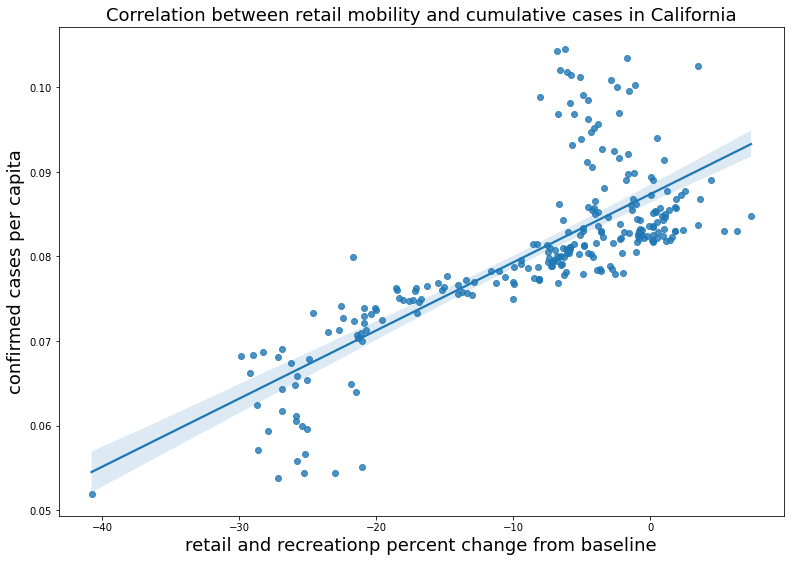

In [76]:
# features2021 = pd.read_csv('data/features_2021.csv')
# eda_features = ['county','retail_and_recreation_percent_change_from_baseline','residential_percent_change_from_baseline','cases','date']
# edaf = features2021.loc[:, eda_features].groupby('date').mean()
# fig = plt.figure(figsize = (13,9))
# sns.regplot(x='retail_and_recreation_percent_change_from_baseline', y='cases', data=edaf)
# plt.xlabel('retail and recreationp percent change from baseline', fontsize = 18)
# plt.ylabel('confirmed cases per capita', fontsize = 18)
# plt.title('Correlation between retail mobility and cumulative cases in California', fontsize = 18)
# plt.savefig('Correlation between retail and recreation mobility and cumulative cases.png')


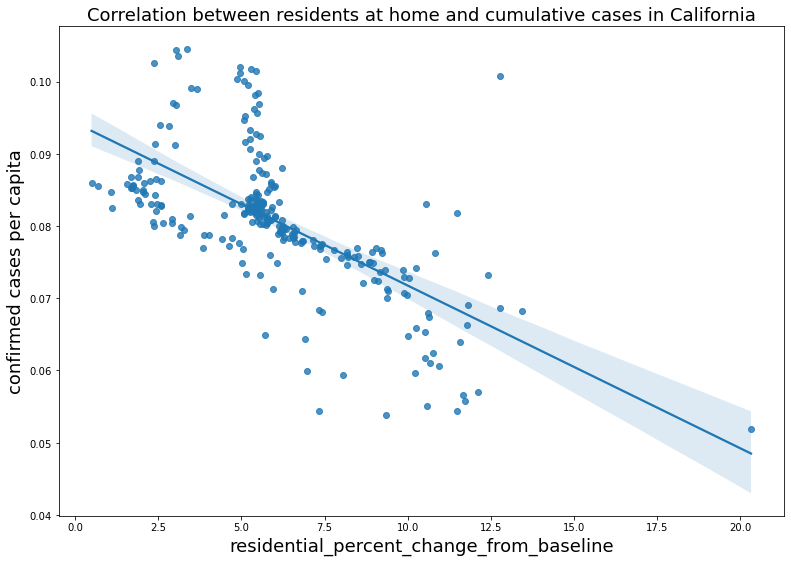

In [77]:
# fig = plt.figure(figsize = (13,9))
# sns.regplot(x='residential_percent_change_from_baseline', y='cases', data=edaf)
# plt.xlabel('residential_percent_change_from_baseline', fontsize = 18)
# plt.ylabel('confirmed cases per capita', fontsize = 18)
# plt.title('Correlation between residents at home and cumulative cases in California', fontsize = 18)
# plt.savefig('Correlation between residents at home and recreation mobility and cumulative cases.png')

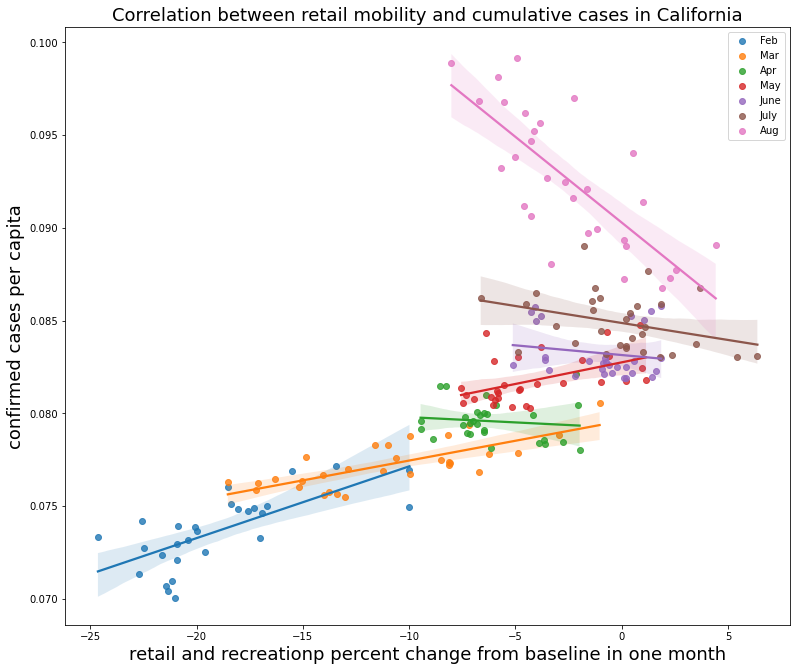

In [78]:
# def remove_outlier(df, col_name, n):
#     return df[abs(df[col_name] - df[col_name].mean()) <= n * df[col_name].std()]
# edaf = edaf.rename(columns = {'retail_and_recreation_percent_change_from_baseline':'retail',\
#                                      'residential_percent_change_from_baseline':'residential'})
# fig = plt.figure(figsize = (13,11))
# eda_features_Feb = remove_outlier(edaf.loc['2021-02-01':'2021-02-28',:], 'retail',3)
# eda_features_Mar = remove_outlier(edaf.loc['2021-03-01':'2021-03-30',:], 'retail',3)
# eda_features_Apr = remove_outlier(edaf.loc['2021-04-01':'2021-04-30',:],'retail',3)
# eda_features_May =remove_outlier( edaf.loc['2021-05-01':'2021-05-31',:],'retail',3)
# eda_features_June = remove_outlier( edaf.loc['2021-06-01':'2021-06-30',:],'retail',3)
# eda_features_July = remove_outlier(edaf.loc['2021-07-01':'2021-07-31',:],'retail',3)
# eda_features_Aug = remove_outlier(edaf.loc['2021-08-01':'2021-08-30',:],'retail',3)
# sns.regplot(x='retail', y='cases', data=eda_features_Feb, label= 'Feb')
# sns.regplot(x='retail', y='cases', data=eda_features_Mar, label = 'Mar')
# sns.regplot(x='retail', y='cases', data=eda_features_Apr, label = 'Apr')
# sns.regplot(x='retail', y='cases', data=eda_features_May, label = 'May')
# sns.regplot(x='retail', y='cases', data=eda_features_June, label = 'June')
# sns.regplot(x='retail', y='cases', data=eda_features_July, label = 'July')
# sns.regplot(x='retail', y='cases', data=eda_features_Aug, label = 'Aug')
# plt.legend(loc='upper right')
# plt.xlabel('retail and recreationp percent change from baseline in one month', fontsize = 18)
# plt.ylabel('confirmed cases per capita', fontsize = 18)
# plt.title('Correlation between retail mobility and cumulative cases in California', fontsize = 18)
# plt.savefig('Correlation change at home and recreation mobility and cumulative cases.png')

### PCA

Index(['Unnamed: 0', 'country_region_code', 'country_region', 'sub_region_1',
       'county', 'CTFIPS', 'date', 'retail', 'grocery', 'parks', 'stations',
       'workplace', 'residential', 'NEVER', 'RARELY', 'SOMETIMES',
       'FREQUENTLY', 'ALWAYS', 'cases', 'deaths', 'Population',
       'total_partially_vaccinated', 'cumulative_fully_vaccinated'],
      dtype='object')

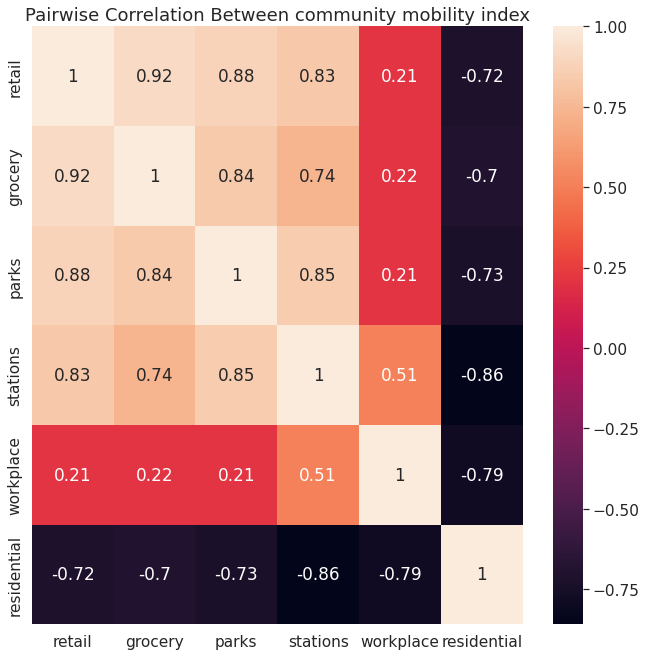

In [79]:
# pca_features = features2021.rename(columns = {'retail_and_recreation_percent_change_from_baseline':'retail',\
#                                      'grocery_and_pharmacy_percent_change_from_baseline':'grocery',\
#                                       'parks_percent_change_from_baseline':'parks',\
#                                       'transit_stations_percent_change_from_baseline':'stations',\
#                                       'workplaces_percent_change_from_baseline':'workplace',\
#                                       'residential_percent_change_from_baseline':'residential'})
# heat_map_features = pca_features.loc[:, ['date','retail','grocery', 'parks', 'stations','workplace', 'residential']].groupby('date').mean()
# heat_map_features = heat_map_features.reset_index()
# fig = plt.figure(figsize = (11,11))
# sns.set(font_scale=1.4) 
# sns.heatmap(heat_map_features.corr(), annot=True)
# plt.title("Pairwise Correlation Between community mobility index", fontsize=18);
# plt.savefig('Pairwise Correlation heatmap.png')
# pca_features.columns

In [80]:
# featurespca = pca_features.loc[:, ['retail','grocery', 'parks', 'stations','workplace', 'residential','cases', 
#        'total_partially_vaccinated', 'cumulative_fully_vaccinated']]
# featurespca
# X = featurespca
# X_prop = (X- X.mean(axis = 0))/np.std((X- X.mean(axis = 0)), axis = 0)
# u, s, vt = np.linalg.svd(X_prop, full_matrices = False)
# X_prop

retail   grocery     parks  stations  workplace  residential  \
0     -3.247275 -3.382815 -0.241409 -2.121067  -4.719883     6.116081   
1     -2.691221 -2.345798 -1.729563 -1.563351  -0.560266     2.181034   
2     -2.444086 -2.106486 -0.875253 -1.284493   0.105273     1.197272   
3     -2.135167 -1.867175 -1.481538 -1.737637  -2.640075     4.148558   
4     -2.011599 -1.229010 -0.627227 -1.667923  -2.556882     3.902617   
...         ...       ...       ...       ...        ...          ...   
10522  0.274400  0.127089  0.805811 -0.308490   0.188465    -0.278371   
10523  0.212616  0.924794 -0.089917  0.040083   0.188465    -0.278371   
10524 -0.034519  0.127089  0.860928  0.284083   0.521234    -0.278371   
10525  0.521535  0.366400  2.817576 -0.134204   2.018697    -1.262133   
10526  0.645103  0.446171  1.356979 -0.180263   1.269965    -1.016192   

          cases  total_partially_vaccinated  cumulative_fully_vaccinated  
0     -1.400388                   -1.673542                    -1.444158  
1     -1.382603                   -1.661415                    -1.444155  
2     -1.365551                   -1.656132                    -1.444128  
3     -1.356088                   -1.630682                    -1.443867  
4     -1.342003                   -1.602440                    -1.443042  
...         ...                         ...                          ...  
10522  0.916311                   -0.356935                     0.448520  
10523  0.916311                   -0.358346                     0.456795  
10524  0.916311                   -0.370346                     0.467025  
10525  0.916311                   -0.379170                     0.472498  
10526  0.916311                   -0.390817                     0.476408  

[10527 rows x 9 columns]

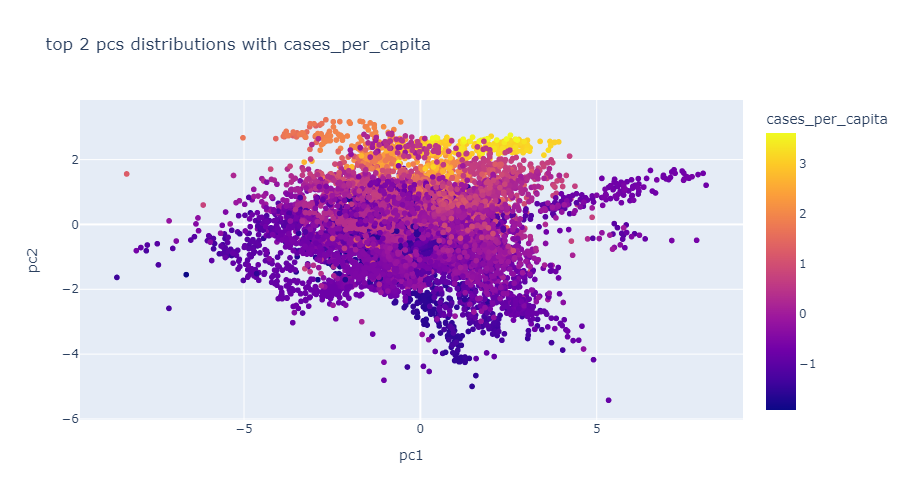

<Figure size 432x288 with 0 Axes>

In [81]:
# pcs = pd.DataFrame(u @ np.diag(s))
# first_2_pcs=pcs.iloc[: , :2].rename(columns={0: "pc1", 1: "pc2"})
# first_2_pcs = pd.merge(first_2_pcs,X_prop['cases'].reset_index(), left_index= True, right_index = True).rename(columns={'cases': 'cases_per_capita'}).drop(columns = 'index')
# fig = px.scatter(first_2_pcs, x="pc1", y="pc2", color= 'cases_per_capita',
#                  title="top 2 pcs distributions with cases_per_capita",  width=800, height=500); 

# fig.update_traces(textposition='top center');
# plt.savefig('allf_pca.png')
# fig.show(); 

In [82]:
# featurespca = pca_features.loc[:, ['retail','grocery', 'parks', 'stations','workplace', 'residential','cases', 
#        'total_partially_vaccinated', 'cumulative_fully_vaccinated']]
# featurespca
# X_mobility= featurespca.loc[:,['retail','grocery', 'parks', 'stations','workplace','residential','cases']]
# X_prop = (X_mobility- X_mobility.mean(axis = 0))/np.std((X_mobility- X_mobility.mean(axis = 0)), axis = 0)
# u, s, vt = np.linalg.svd(X_prop, full_matrices = False)
# X_prop

retail   grocery     parks  stations  workplace  residential  \
0     -3.247275 -3.382815 -0.241409 -2.121067  -4.719883     6.116081   
1     -2.691221 -2.345798 -1.729563 -1.563351  -0.560266     2.181034   
2     -2.444086 -2.106486 -0.875253 -1.284493   0.105273     1.197272   
3     -2.135167 -1.867175 -1.481538 -1.737637  -2.640075     4.148558   
4     -2.011599 -1.229010 -0.627227 -1.667923  -2.556882     3.902617   
...         ...       ...       ...       ...        ...          ...   
10522  0.274400  0.127089  0.805811 -0.308490   0.188465    -0.278371   
10523  0.212616  0.924794 -0.089917  0.040083   0.188465    -0.278371   
10524 -0.034519  0.127089  0.860928  0.284083   0.521234    -0.278371   
10525  0.521535  0.366400  2.817576 -0.134204   2.018697    -1.262133   
10526  0.645103  0.446171  1.356979 -0.180263   1.269965    -1.016192   

          cases  
0     -1.400388  
1     -1.382603  
2     -1.365551  
3     -1.356088  
4     -1.342003  
...         ...  
10522  0.916311  
10523  0.916311  
10524  0.916311  
10525  0.916311  
10526  0.916311  

[10527 rows x 7 columns]

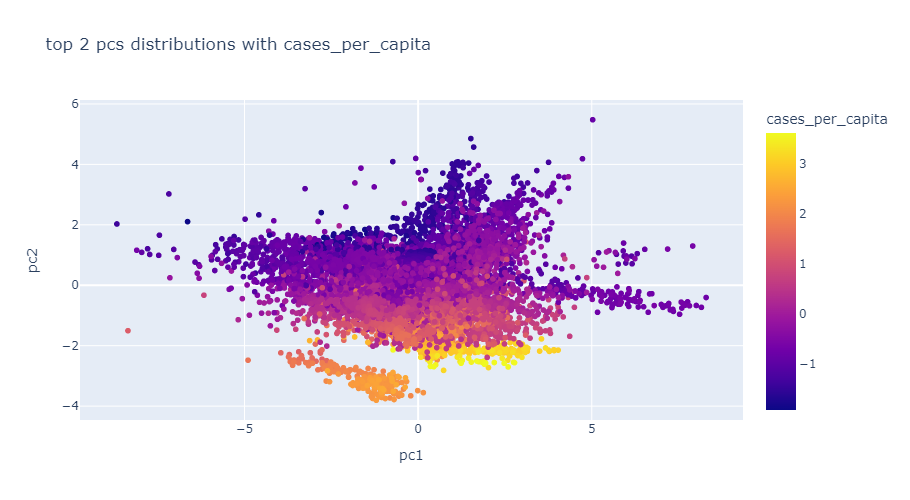

<Figure size 432x288 with 0 Axes>

In [83]:
# pcs = pd.DataFrame(u @ np.diag(s))
# first_2_pcs=pcs.iloc[: , :2].rename(columns={0: "pc1", 1: "pc2"})
# first_2_pcs = pd.merge(first_2_pcs,X_prop['cases'].reset_index(), left_index= True, right_index = True).rename(columns={'cases': 'cases_per_capita'}).drop(columns = 'index')
# fig = px.scatter(first_2_pcs, x="pc1", y="pc2", color= 'cases_per_capita',
#                  title="top 2 pcs distributions with cases_per_capita",  width=800, height=500); 

# fig.update_traces(textposition='top center');
# plt.savefig('mobility_pca.png')
# fig.show(); 

<!-- BEGIN QUESTION -->

### Question 6a

Train a baseline model where $f$ is the model described in Question 0a and $x$ is a quantity of *your* choice. Note that you may used *any* supervised learning approach we have studied; you are not limited to a linear model.

<!--
BEGIN QUESTION
name: q6a
points: 0
manual: True
-->

In [84]:
# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import log_loss, accuracy_score, r2_score

# def standard_units(x):
#     return (x - x.mean()) / x.std() 

# def rmse(predicted, actual):
#     return np.sqrt(np.mean((actual - predicted)**2))

# def correlation(x, y):
#     return np.sum(standard_units(x)*standard_units(y))/len(x)

# def rmse_loss(predict, y):
#     return np.sqrt(sum((predict.reset_index(drop=True) - y.reset_index(drop=True)) ** 2) / y.shape[0])

# def remove_outlier(df, col_name, n):
#     return df[(df[col_name] - df[col_name].mean()) <= n * df[col_name].std()]

# features_2021 = pd.read_csv('./data/features_2021.csv')
# features_time_series = pd.read_csv('./data/features_time_series.csv')
# features_time_series['month'] = pd.to_datetime(features_time_series['date']).dt.month

Feature standarize

In [85]:
# features_std = features_time_series.copy()
# features_std.loc[:, 'retail_and_recreation_percent_change_from_baseline':'prior_7_days_residential'] = features_std.loc[:, 'retail_and_recreation_percent_change_from_baseline':'prior_7_days_residential'].apply(standard_units, axis=0)
# features = features_std.loc[:, 'retail_and_recreation_percent_change_from_baseline':]
# fe = features
# features_columns = list(features.columns.values)
# features_columns.pop()
# fe = fe[np.isfinite(fe).all(1)]

Baseline model with 2 days features

RMSE loss is 0.6704690147728898 stddev of y_test is 0.9161870923135337
R2 score is 0.4644634872820037


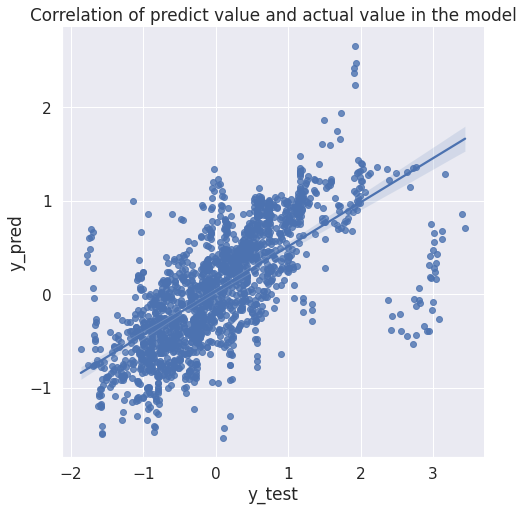

In [86]:
# linear_model_baseline = LinearRegression(normalize=True)

# baseline_fe = fe.copy()
# for i in features_columns:
#     baseline_fe = remove_outlier(baseline_fe, i, 4)

# X = baseline_fe[['prior_1_days_par_vacci', 'prior_2_days_par_vacci', 'total_partially_vaccinated',
#                 'prior_1_days_ful_vacci', 'prior_2_days_ful_vacci', 'cumulative_fully_vaccinated',
#                 'prior_1_days_retail', 'prior_2_days_retail', 'retail_and_recreation_percent_change_from_baseline',
#                 'prior_1_days_grocery', 'prior_2_days_grocery', 'grocery_and_pharmacy_percent_change_from_baseline',
#                 'prior_1_days_parks', 'prior_2_days_parks', 'parks_percent_change_from_baseline',
#                 'prior_1_days_transit', 'prior_2_days_transit', 'transit_stations_percent_change_from_baseline',
#                 'prior_1_days_workplaces', 'prior_2_days_workplaces', 'workplaces_percent_change_from_baseline',
#                 'prior_1_days_residential', 'prior_2_days_residential', 'residential_percent_change_from_baseline',
#                 'deaths'
#                 ]]

# y = baseline_fe['cases']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# linear_model_baseline.fit(X_train, y_train)

# y_pred = pd.Series(linear_model_baseline.predict(X_test))
# loss = rmse_loss(y_pred, y_test)
# print(f'RMSE loss is {loss} stddev of y_test is {np.std(y_test)}')
# print(f'R2 score is {r2_score(y_test, y_pred)}')

# coef_dict_baseline = {}
# coef_lst_baseline = list(linear_model_baseline.coef_)
# X_columns = list(X.columns.values)
# for i in range(len(X_columns)):
#     coef_dict_baseline[X_columns[i]] = coef_lst_baseline[i]
    
# coef_dict_baseline=sorted(coef_dict_baseline.items(),key=lambda x:x[1],reverse=False)
# y_test_df = y_test.to_frame().reset_index()
# predict_df = y_pred.to_frame().join(y_test_df)
# predict_df.rename(columns={'cases': 'y_test', 0: 'y_pred'}, inplace=True)
# sns.pairplot(predict_df, x_vars='y_test', y_vars='y_pred', size=7, aspect=1, kind = 'reg')
# plt.title("Correlation of predict value and actual value in the model")
# plt.show()

In [87]:
# from sklearn.model_selection import cross_val_score
# cv_4_results = cross_val_score(linear_model, X, y, cv=4, scoring='neg_mean_squared_error')
# cv_4_results

array([-0.76110288, -1.72357788, -0.17445137, -0.11332688])

hypo modeling

In [88]:
# linear_model_baseline = LinearRegression(normalize=True)

# RMSE_dict = {}
# stddev_dict = {}
# coef_dict = {}
# R2_dict = {}
# for j in range(len(features_columns)):
#     coef_dict[features_columns[j]] = []
# for i in range(2, 9):
#     # month_fe = fe[(fe['month'] == i) | (fe['month'] == i-1)]
#     month_fe = fe[(fe['month'] == i)]

#     for feature in features_columns:
#         month_fe = remove_outlier(month_fe, feature, 4)
    
#     X = month_fe[['prior_1_days_par_vacci', 'prior_2_days_par_vacci', 'total_partially_vaccinated',
#                 'prior_1_days_ful_vacci', 'prior_2_days_ful_vacci', 'cumulative_fully_vaccinated',
#                 'prior_1_days_retail', 'prior_2_days_retail', 'retail_and_recreation_percent_change_from_baseline',
#                 'prior_1_days_grocery', 'prior_2_days_grocery', 'grocery_and_pharmacy_percent_change_from_baseline',
#                 'prior_1_days_parks', 'prior_2_days_parks', 'parks_percent_change_from_baseline',
#                 'prior_1_days_transit', 'prior_2_days_transit', 'transit_stations_percent_change_from_baseline',
#                 'prior_1_days_workplaces', 'prior_2_days_workplaces', 'workplaces_percent_change_from_baseline',
#                 'prior_1_days_residential', 'prior_2_days_residential', 'residential_percent_change_from_baseline',
#                 'deaths'
#                 ]]
    
#     y = month_fe['cases']

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

#     linear_model_baseline.fit(X_train, y_train)

#     y_pred = pd.Series(linear_model_baseline.predict(X_test))
#     loss = rmse_loss(y_pred, y_test)
#     RMSE_dict[i] = loss
#     stddev_dict[i] = np.std(y_test)
#     R2_dict[i] = r2_score(y_test, y_pred)

#     coef_lst = list(linear_model_baseline.coef_)
#     X_columns = list(X.columns.values)
#     for k in range(len(X_columns)):
#         coef_dict[X_columns[k]].append(coef_lst[k])

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6b

Improve your model from part (a). Specify the supervised model you choose and write $f(x)$ as a function of the chosen features and parameters in your model. Justify why you chose these features and how you expect they will correlate with the output you wish to predict.

<!--
BEGIN QUESTION
name: q6b
points: 0
manual: True
-->

In [90]:
# features_std['datetime'] = pd.to_datetime(features_std['date'])
# features_std['weekday'] = (features_std['datetime'].dt.dayofweek < 5).astype('int')

In [91]:
# features_std.loc[:, ['datetime']] = features_std.loc[:, ['datetime']].apply(standard_units, axis=0)
# features_improve = features_std.loc[:, 'retail_and_recreation_percent_change_from_baseline':]
# fe_improve = features_improve.copy()
# fe_improve = fe_improve[np.isfinite(fe_improve).all(1)]

1. input datetime and weekdays

RMSE loss is 0.45998461287195896 stddev of y_test is 0.8289744210794683
R2 score is 0.6921037864303459


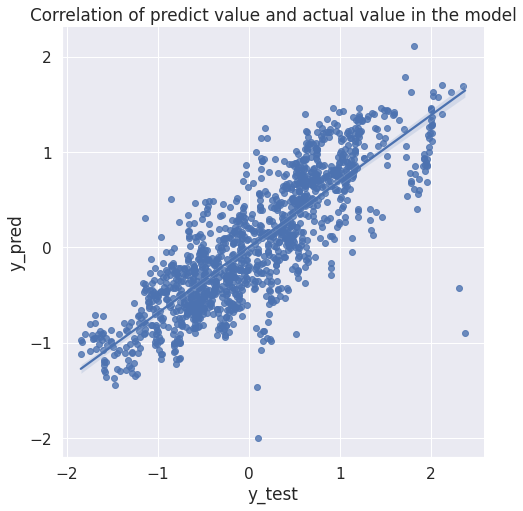

In [92]:
# linear_model_improve1 = LinearRegression(normalize=True)

# fe_remove = fe_improve.copy()
# features_columns = list(features_improve.loc[:, 'retail_and_recreation_percent_change_from_baseline': 'prior_7_days_residential'].columns.values)
# for i in features_columns:
#     fe_remove = remove_outlier(fe_remove, i, 3)

# X = fe_remove[['prior_1_days_par_vacci', 'prior_2_days_par_vacci', 'total_partially_vaccinated',
#                 'prior_1_days_ful_vacci', 'prior_2_days_ful_vacci', 'cumulative_fully_vaccinated',
#                 'prior_1_days_retail', 'prior_2_days_retail', 'retail_and_recreation_percent_change_from_baseline',
#                 'prior_1_days_grocery', 'prior_2_days_grocery', 'grocery_and_pharmacy_percent_change_from_baseline',
#                 'prior_1_days_parks', 'prior_2_days_parks', 'parks_percent_change_from_baseline',
#                 'prior_1_days_transit', 'prior_2_days_transit', 'transit_stations_percent_change_from_baseline',
#                 'prior_1_days_workplaces', 'prior_2_days_workplaces', 'workplaces_percent_change_from_baseline',
#                 'prior_1_days_residential', 'prior_2_days_residential', 'residential_percent_change_from_baseline',
#                 'deaths', 'datetime', 'weekday']]

# y = fe_remove['cases']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# linear_model_improve1.fit(X_train, y_train)

# y_pred = pd.Series(linear_model_improve1.predict(X_test))
# loss = rmse_loss(y_pred, y_test)
# print(f'RMSE loss is {loss} stddev of y_test is {np.std(y_test)}')
# print(f'R2 score is {r2_score(y_test, y_pred)}')
# # fig = px.scatter(y=y_pred, x=y_test)
# # fig.show()

# improve1_coef_dict = {}
# improve1_coef_lst = list(linear_model_improve1.coef_)
# X_columns = list(X.columns.values)
# for i in range(len(X_columns)):
#     improve1_coef_dict[X_columns[i]] = improve1_coef_lst[i]
    
# improve_coef_dict = sorted(improve1_coef_dict.items(),key=lambda x:x[1],reverse=False)
# y_test_df = y_test.to_frame().reset_index()
# predict_df = y_pred.to_frame().join(y_test_df)
# predict_df.rename(columns={'cases': 'y_test', 0: 'y_pred'}, inplace=True)
# sns.pairplot(predict_df, x_vars='y_test', y_vars='y_pred', size=7, aspect=1, kind = 'reg')
# plt.title("Correlation of predict value and actual value in the model")
# plt.show()

2. time series. input 7 days data rather than 2 days

RMSE loss is 0.44225345561723944 stddev of y_test is 0.8289744210794683
R2 score is 0.7153834108179024


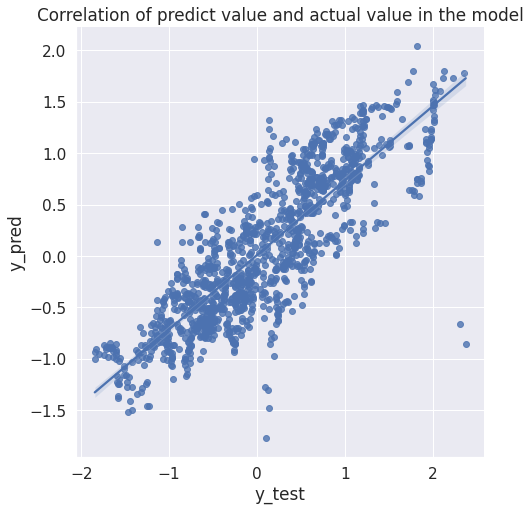

In [93]:
# linear_model_improve2 = LinearRegression(normalize=True)

# X = fe_remove.drop(columns=['cases', 'prior_1_days_cases', 'prior_2_days_cases', 'prior_3_days_cases', 
#                            'prior_4_days_cases', 'prior_5_days_cases', 'prior_6_days_cases', 'prior_7_days_cases',
#                             'ALWAYS', 'FREQUENTLY', 'SOMETIMES', 'NEVER', 'RARELY', 'Population'])

# y = fe_remove['cases']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# linear_model_improve2.fit(X_train, y_train)

# y_pred = pd.Series(linear_model_improve2.predict(X_test))
# loss = rmse_loss(y_pred, y_test)
# print(f'RMSE loss is {loss} stddev of y_test is {np.std(y_test)}')
# print(f'R2 score is {r2_score(y_test, y_pred)}')
# # fig = px.scatter(y=y_pred, x=y_test)
# # fig.show()

# improve2_coef_dict = {}
# improve2_coef_lst = list(linear_model_improve2.coef_)
# X_columns = list(X.columns.values)
# for i in range(len(X_columns)):
#     improve2_coef_dict[X_columns[i]] = improve2_coef_lst[i]
    
# improve2_coef_dict = sorted(improve2_coef_dict.items(),key=lambda x:x[1],reverse=False)
# y_test_df = y_test.to_frame().reset_index()
# predict_df = y_pred.to_frame().join(y_test_df)
# predict_df.rename(columns={'cases': 'y_test', 0: 'y_pred'}, inplace=True)
# sns.pairplot(predict_df, x_vars='y_test', y_vars='y_pred', size=7, aspect=1, kind = 'reg')
# plt.title("Correlation of predict value and actual value in the model")
# plt.show()

3. hypo evaluation: With vaccination and without vaccination

In [94]:
# linear_model = LinearRegression(normalize=True)

# RMSE_dict = {}
# stddev_dict = {}
# coef_dict = {}
# R2_dict = {}
# features_columns = list(features_improve.columns.values)
# for j in range(len(features_columns)):
#     coef_dict[features_columns[j]] = []

# for i in range(2, 9):
#     # month_fe = fe_improve[(fe_improve['month'] == i) | (fe_improve['month'] == i-1)]
#     month_fe = fe_improve[(fe_improve['month'] == i)]

#     for feature in features_columns:
#         month_fe = remove_outlier(month_fe, feature, 3)
    
#     X = month_fe.drop(columns=['cases', 'prior_1_days_cases', 'prior_2_days_cases', 'prior_3_days_cases', 
#                            'prior_4_days_cases', 'prior_5_days_cases', 'prior_6_days_cases', 'prior_7_days_cases',
#                             'ALWAYS', 'FREQUENTLY', 'SOMETIMES', 'NEVER', 'RARELY', 'Population'])
    
#     y = month_fe['cases']

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

#     linear_model.fit(X_train, y_train)

#     y_pred = pd.Series(linear_model.predict(X_test))
#     loss = rmse_loss(y_pred, y_test)
#     RMSE_dict[i] = loss
#     stddev_dict[i] = np.std(y_test)
#     R2_dict[i] = r2_score(y_test, y_pred)

#     coef_lst = list(linear_model.coef_)
#     X_columns = list(X.columns.values)
#     for k in range(len(X_columns)):
#         coef_dict[X_columns[k]].append(coef_lst[k])

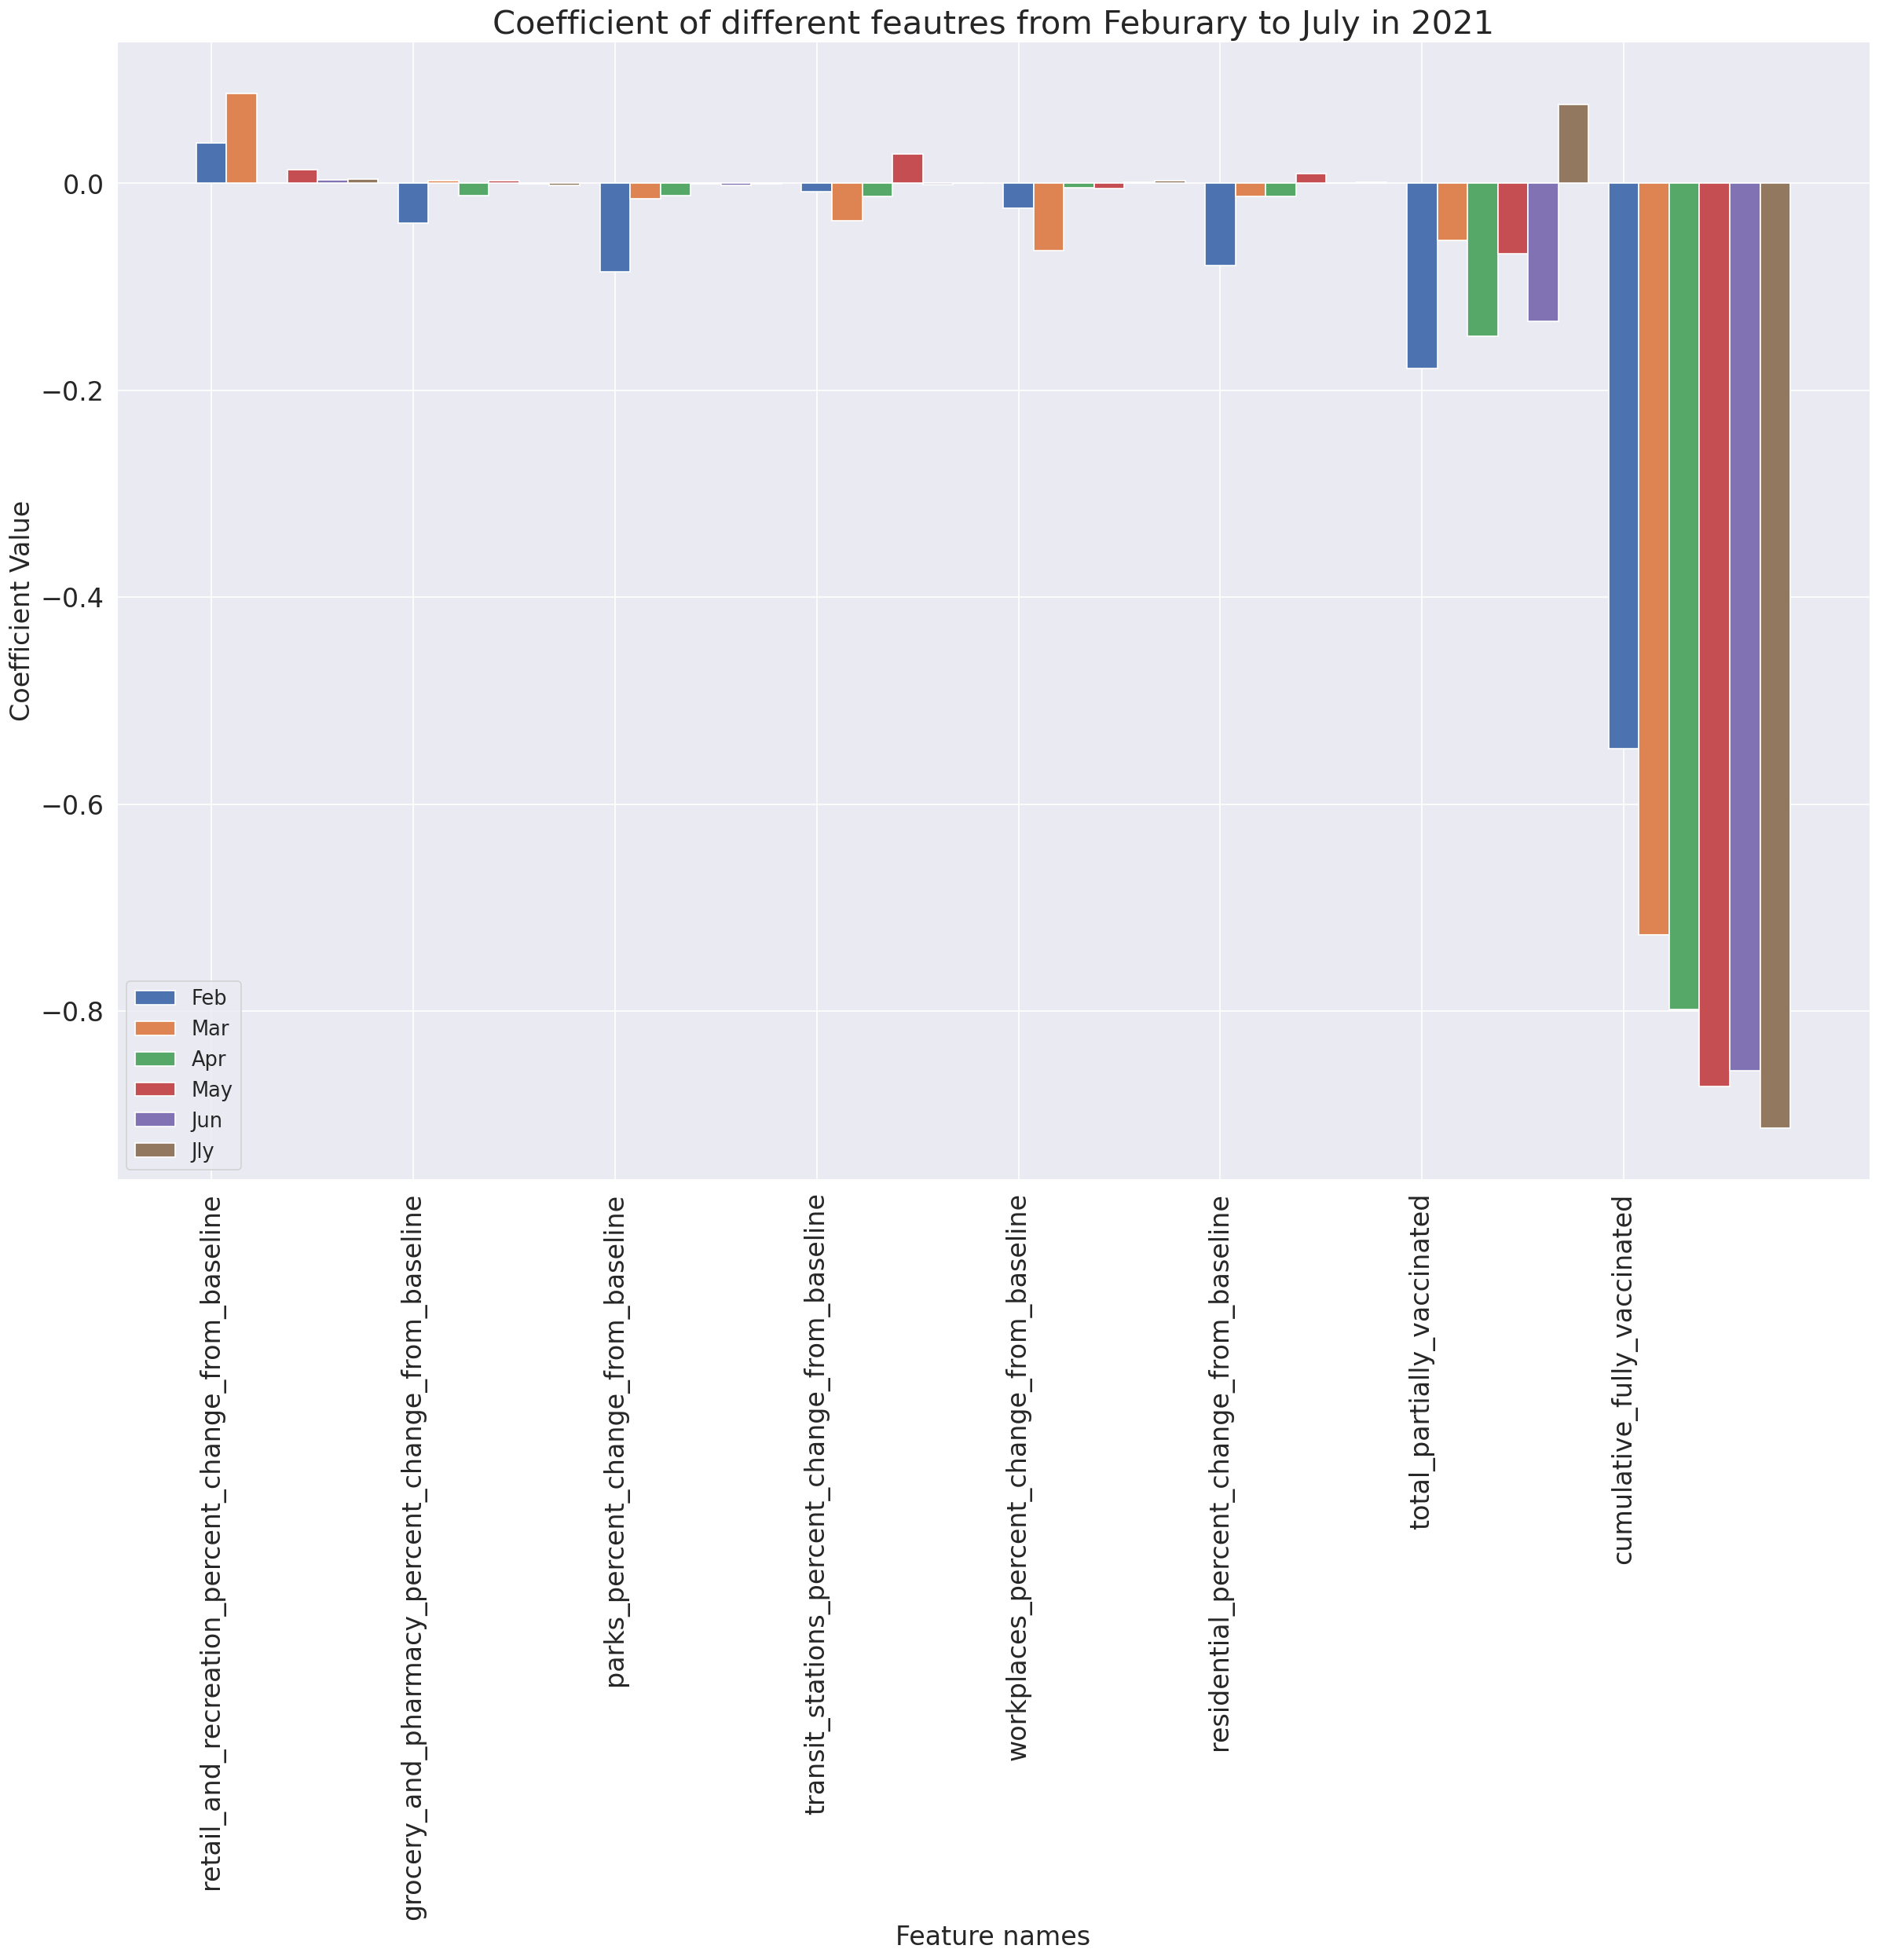

<Figure size 432x288 with 0 Axes>

In [106]:
# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import log_loss, accuracy_score, r2_score

# linear_model = LinearRegression(normalize=True)

# RMSE_dict = {}
# stddev_dict = {}
# coef_dict = {}
# R2_dict = {}
# for j in range(len(features_columns)):
#     coef_dict[features_columns[j]] = []
# for i in range(2, 8):
#     #month_fe = fe[(fe['month'] == i) | (fe['month'] == i-1)]
#     month_fe = fe[(fe['month'] == i)]
#     # features_columns = list(month_fe.columns.values)
#     # features_columns.pop()

#     for feature in features_columns:
#         month_fe = remove_outlier(month_fe, feature, 4)
    
#     X = month_fe.drop(columns=['cases', 'prior_1_days_cases', 'prior_2_days_cases', 'prior_3_days_cases', 
#                                'prior_4_days_cases', 'prior_5_days_cases', 'prior_6_days_cases', 'prior_7_days_cases', 'month',
#                               'ALWAYS', 'FREQUENTLY', 'SOMETIMES', 'NEVER', 'RARELY', 'Population', 'deaths'])
#     y = month_fe['cases']

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

#     linear_model.fit(X_train, y_train)

#     y_pred = pd.Series(linear_model.predict(X_test))
#     loss = rmse_loss(y_pred, y_test)
#     RMSE_dict[i] = loss
#     stddev_dict[i] = np.std(y_test)
#     R2_dict[i] = r2_score(y_test, y_pred)
#     # print(f'RMSE loss is {loss} stddev of y_test is {np.std(y_test)}')
#     # print(f'R2 score is {r2_score(y_test, y_pred)}')
#     # fig = px.scatter(y=y_pred, x=y_test)
#     # fig.show()

#     coef_lst = list(linear_model.coef_)
#     X_columns = list(X.columns.values)
#     for k in range(len(X_columns)):
#         coef_dict[X_columns[k]].append(coef_lst[k])

# # coef_dict=sorted(coef_dict.items(),key=lambda x:x[1],reverse=False)
# #print(R2_dict)
# #print(coef_dict)

# vis = dict()
# show = dict()
# coef0 = []
# coef5 = []
# for i in range(6):
        
#     vis[i] = dict()
#     res = 0
#     for key in coef_dict:
#         if not coef_dict[key]:
#             continue
#         if "baseline" in key or "vaccinated" in key:
#             vis[i][key] = coef_dict[key][i]
#             res += abs(vis[i][key])
#     for key in vis[i]:
#         if i == 0:
#             coef0.append(vis[i][key])
#         if i == 5:
#             coef5.append(vis[i][key])
#         vis[i][key] = vis[i][key]/ res
#         if key not in show:
#             show[key] = []
#         show[key].append(vis[i][key])

    
# xlabels = vis[0].keys()
# bar_width = 0.15 
# x_Feb = list(range(len(xlabels)))
# x_Mar = [i+bar_width for i in x_Feb]
# x_Apr = [i+bar_width*2 for i in x_Feb]
# x_May = [i+bar_width*3 for i in x_Feb]
# x_Jun = [i+bar_width*4 for i in x_Feb]
# x_Jly = [i+bar_width*5 for i in x_Feb]

# plt.figure(figsize=(24,16),dpi=120)

# # 绘制三个条形图
# plt.bar(x_Feb, vis[0].values(), width=bar_width, label="Feb")
# plt.bar(x_Mar, vis[1].values(), width=bar_width, label="Mar")
# plt.bar(x_Apr, vis[2].values(), width=bar_width, label="Apr")
# plt.bar(x_May, vis[3].values(), width=bar_width, label="May")
# plt.bar(x_Jun, vis[4].values(), width=bar_width, label="Jun")
# plt.bar(x_Jly, vis[5].values(), width=bar_width, label="Jly")


# # 设置图例
# plt.legend()
 
# # 设置x轴的刻度
# plt.xticks(x_Feb, xlabels, rotation = 90, fontsize=20)
# plt.yticks(fontsize=20)
# plt.xlabel("Feature names", fontsize = 20)
# plt.ylabel("Coefficient Value", fontsize = 20)
# plt.title("Coefficient of different feautres from Feburary to July in 2021",fontsize = 25);
# plt.show()
# plt.savefig('coefficient values.png')
# print()


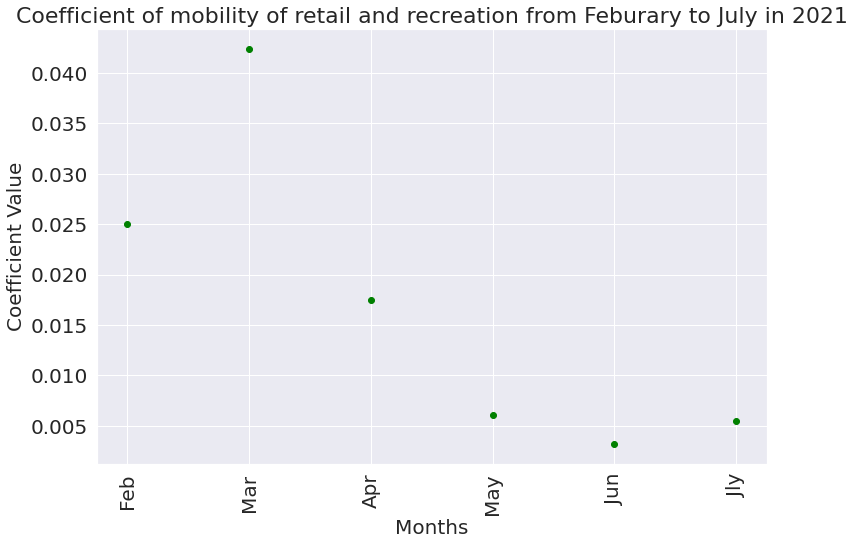

In [97]:
# def plotscatter(d, name, color, nickname):
#     plt.figure(figsize=(12,8))
#     xlabels = ['Feb','Mar','Apr','May','Jun','Jly']
#     plt.xticks(np.arange(6), xlabels, rotation = 90, fontsize=20)
#     plt.yticks(fontsize=20)
#     plt.xlabel("Months", fontsize = 20)
#     plt.ylabel("Coefficient Value", fontsize = 20)
#     plt.title(f"Coefficient of mobility of {nickname} from Feburary to July in 2021",fontsize = 22);
#     plt.plot(np.arange(6), d[name], 'o', color='green')
#     plt.show()
# plotscatter(show, 'retail_and_recreation_percent_change_from_baseline', 'blue', 'retail and recreation')

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6c

If applicable, write an equation or rule for the prediction function $f(x)$; if this is infeasible, make sure to visualize your model parameters in some way. Interpret your improved model's optimal parameters (*hint*: refer to 1aiii), and compare these parameters to those of the baseline model. Comment on whether the parameters follow physical intuition given the nature of the prediction task.

For example, if you chose to use a decision tree, you may interpret the generated rules.
 
<!--
BEGIN QUESTION
name: q6c
points: 0
manual: True
-->

_The parameters of the prediction function are shown in the following graph._

In [98]:
# # coef process
# improve2_coef_dict = dict(improve2_coef_dict)
# improve1_coef_dict = dict(improve1_coef_dict)
# baseline_coef_dict = dict(coef_dict_baseline)
# keys_list = list(improve2_coef_dict.keys())
# improve2_value_list = list(improve2_coef_dict.values())
# baseline_keys = list(baseline_coef_dict.keys())
# improve1_keys = list(improve1_coef_dict.keys())
# baseline_list = []
# improve1_list = []
# for i in keys_list:
#     if i not in improve1_keys:
#         improve1_list.append(0)
#     else:
#         improve1_list.append(improve1_coef_dict[i])
#     if i not in baseline_keys:
#         baseline_list.append(0)
#     else:
#         baseline_list.append(baseline_coef_dict[i])

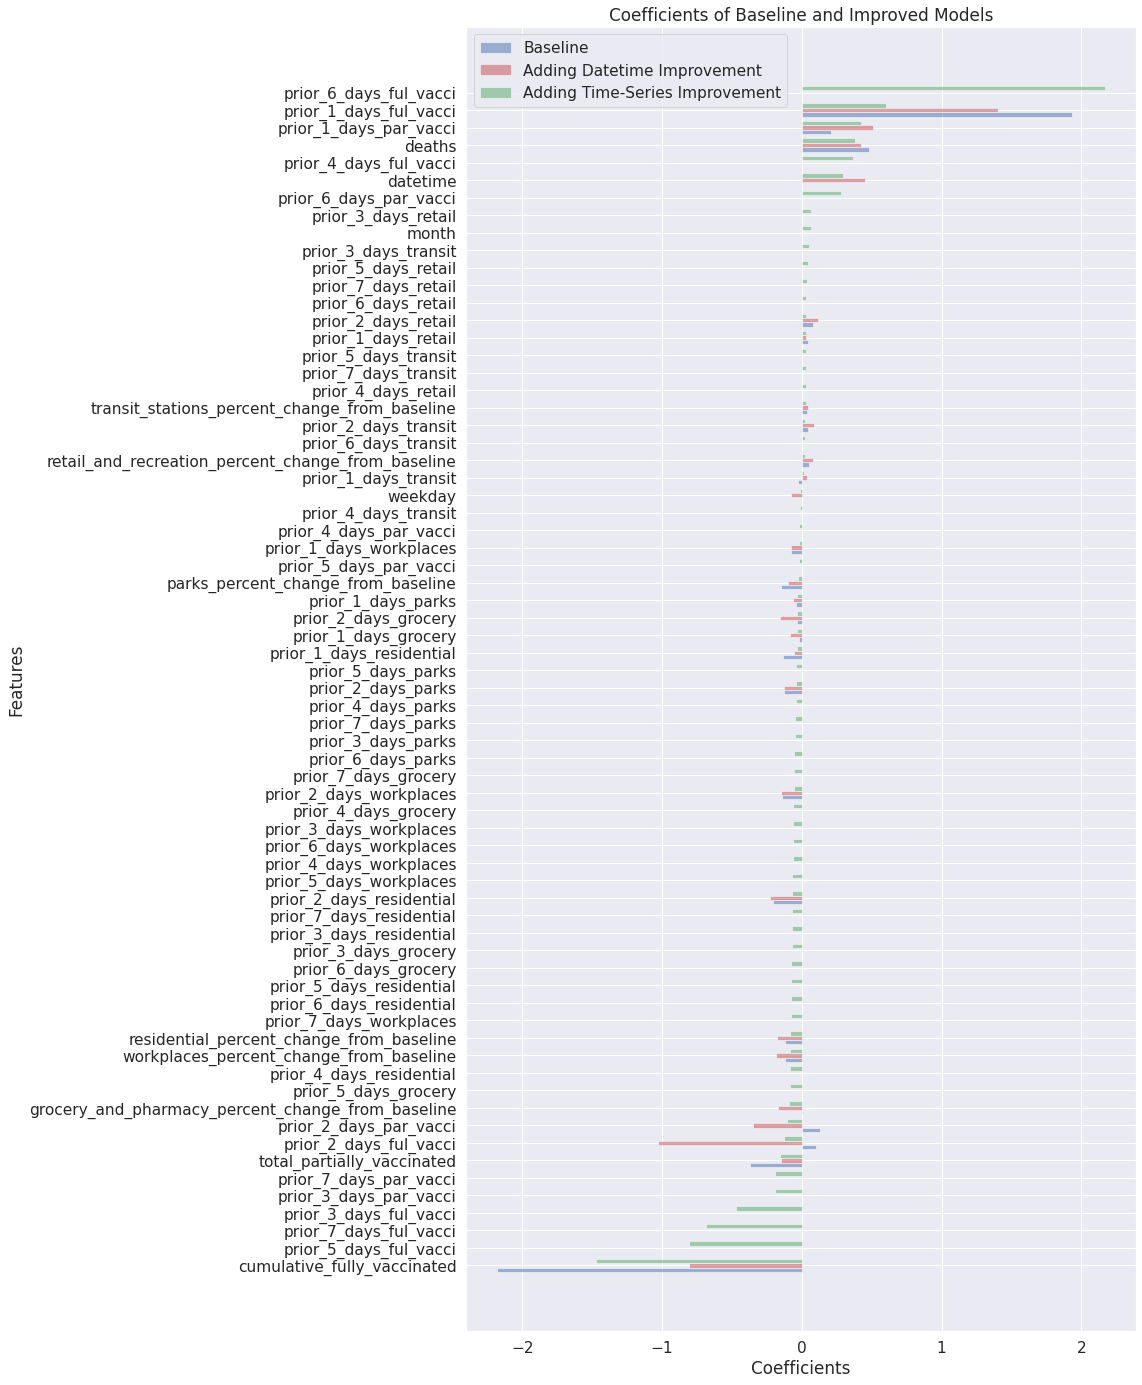

In [99]:
# indices = range(len(improve2_value_list))

# width = np.min(np.diff(indices))/4.

# fig = plt.figure(figsize=(12,24))

# ax = fig.add_subplot(111)

# ax.barh(indices-width, baseline_list, width, color='b', alpha=0.5, label='Baseline')
# ax.barh(indices, improve1_list, width, color='r', alpha=0.5, label='Adding Datetime Improvement')
# ax.barh(indices+width, improve2_value_list, width, color='g', alpha=0.5, label='Adding Time-Series Improvement')

# ax.axes.set_yticks(indices)
# ax.axes.set_yticklabels(keys_list)
# ax.set_xlabel('Coefficients')
# ax.set_ylabel('Features')
# plt.legend(loc='upper left')
# plt.title("Coefficients of Baseline and Improved Models")
# plt.savefig('Coefficients.png', dpi=300, bbox_inches='tight')
# plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6d

Discuss your improved model's performance on both short-term and long-term time scales using a metric of your choice (*hint:* we're using an autoregressive model). In other words, given $x_t$, we wish to predict $\hat{x}_{t+k}$, and plot the error of these predictions for two $k$ values of your choice. You may use any reasonable interpretation of short-term and long-term predictions; an initial suggestion is to use 2-day predictions and 2-week predictions.

Compare the performance of this model on both timescales with the baseline model.

<!--
BEGIN QUESTION
name: q6d
points: 0
manual: True
-->

Answer: We compare 7 days and 2 days predictions in q6b.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6e

Plot and describe the error for both the baseline and improved models as a function of time. In other words, given $x_t$, we wish to predict $\hat{x}_{t+k}$, and plot the error of these predictions for all $k$.

Consider how and why the performance of the model degrades as a function of time using the rate of growth in the error.

<!--
BEGIN QUESTION
name: q6e
points: 0
manual: True
-->

In [100]:
# features_6f = features_std
# features_6f.head(5)
# y_6f = pd.DataFrame(np.zeros((features_6f.shape[0],8))).rename(columns = {0:'days_0',1:'days_1',2:'days_2',3:'days_3',\
#                                                                          4:'days_4',5:'days_5',6:'days_6',7:'days_7'})
# countynames = features_6f['county'].unique()
# countynames
# for ctname in countynames:
#     idx = features_6f['county'] == ctname
#     dfcounty = features_6f[idx]
#     dfcountyIdx = dfcounty.index
#     for rowIdx in dfcountyIdx[:-8]:
#         temp = features_6f.loc[rowIdx:rowIdx+7,'cases'].to_numpy()
#         y_6f.loc[rowIdx,:] = temp
# tojitter = (y_6f==0).all(axis=1)
# fall6f = pd.merge(features_6f, y_6f , left_index= True, right_index=True)
# fall6f = fall6f[~tojitter]
# # fall6f

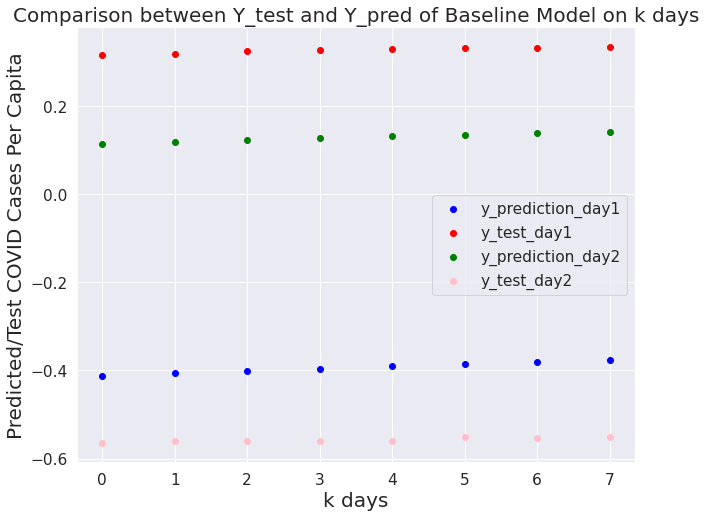

No handles with labels found to put in legend.


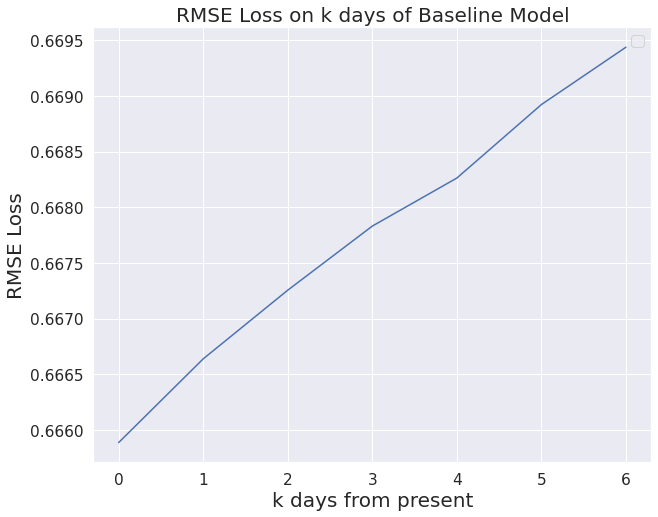

[0.6658866350909012, 0.6666386368665644, 0.6672556406637717, 0.6678314780055546, 0.6682631906320622, 0.6689234538590987, 0.6694388579160033]
[-0.07637311739138641, -0.07820603035555207, -0.07948739626102563, -0.08070834645213587, -0.08178780936339192, -0.08285971052238428, -0.08322738107263539]


In [101]:
# linear_model = LinearRegression(normalize=True)

# def rmse_loss6f(predict, y):
#     return np.sqrt(sum((predict.reset_index(drop=True) - y.reset_index(drop=True)) ** 2) / y.shape[0])
# baseline_fe = fall6f.copy()
# for i in features_columns:
#     baseline_fe = remove_outlier(baseline_fe, i, 4)

# X = baseline_fe[['prior_1_days_par_vacci', 'prior_2_days_par_vacci', 'total_partially_vaccinated',
#                 'prior_1_days_ful_vacci', 'prior_2_days_ful_vacci', 'cumulative_fully_vaccinated',
#                 'prior_1_days_retail', 'prior_2_days_retail', 'retail_and_recreation_percent_change_from_baseline',
#                 'prior_1_days_grocery', 'prior_2_days_grocery', 'grocery_and_pharmacy_percent_change_from_baseline',
#                 'prior_1_days_parks', 'prior_2_days_parks', 'parks_percent_change_from_baseline',
#                 'prior_1_days_transit', 'prior_2_days_transit', 'transit_stations_percent_change_from_baseline',
#                 'prior_1_days_workplaces', 'prior_2_days_workplaces', 'workplaces_percent_change_from_baseline',
#                 'prior_1_days_residential', 'prior_2_days_residential', 'residential_percent_change_from_baseline',
#                 'deaths'
#                 ]]

# y = baseline_fe.loc[:,'days_0':'days_7']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# linear_model.fit(X_train, y_train)
# plt.figure(figsize=(10, 8))
# y_pred = linear_model.predict(X_test)
# y_pred = pd.DataFrame(y_pred)
# plt.scatter(np.arange(len(y_pred.iloc[0,:])), y_pred.iloc[0,:], color = 'blue',label = 'y_prediction_day1')
# plt.scatter(np.arange(len(y_test.iloc[0,:])), y_test.iloc[0,:], color = 'red',label = 'y_test_day1')
# plt.scatter(np.arange(len(y_pred.iloc[1,:])), y_pred.iloc[1,:], color = 'green',label = 'y_prediction_day2')
# plt.scatter(np.arange(len(y_test.iloc[1,:])), y_test.iloc[1,:], color = 'pink',label = 'y_test_day2')
# plt.xlabel("k days", fontsize = 20)
# plt.ylabel("Predicted/Test COVID Cases Per Capita", fontsize = 20)
# plt.title("Comparison between Y_test and Y_pred of Baseline Model on k days", fontsize = 20);
# plt.legend()
# plt.savefig('Comparison between Y_test and Y_pred of Baseline Model on k days.png')
# plt.show()
# rese_loss = []
# r2_scores = []
# for i in range(7):
    
#     loss = rmse_loss6f(y_pred.iloc[:,i], y_test.iloc[:,i])
#     r2 = r2_score(y_pred.iloc[:,i], y_test.iloc[:,i])
#     rese_loss.append(loss)
#     r2_scores.append(r2)
    
# plt.figure(figsize=(10, 8))
# plt.plot(np.arange(len(rese_loss)), rese_loss)
# plt.xlabel("k days from present", fontsize = 20)
# plt.ylabel("RMSE Loss", fontsize = 20)
# plt.title("RMSE Loss on k days of Baseline Model", fontsize = 20);
# plt.legend()
# plt.savefig('RMSE Loss on k days of Baseline Model.png')
# plt.show()
# print(rese_loss)
# print(r2_scores)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6f

Consider a modification to the model $f(x) = x_{t+1}$ where instead $f(x) = [x_{t+1}, x_{t+2}, ..., x_{t+m}]$ for some $m > 1$. In other words, using the features $x$ that contain past and present quantities, our model *explicitly* predicts values for $m$ days in the future rather than simply the next day (i.e. $m = 1$). 

Train the baseline and improved model using $m = 5$ and $m = 10$. Evaluate and visualize the predictive accuracy of both models.

<!--
BEGIN QUESTION
name: q6f
points: 0
manual: True
-->

In [102]:
# features_6h = features_std
# y_6h = pd.DataFrame(np.zeros((features_6h.shape[0],8))).rename(columns = {0:'days_0',1:'days_1',2:'days_2',3:'days_3',\
#                                                                          4:'days_4',5:'days_5',6:'days_6',7:'days_7'})
# countynames = features_6h['county'].unique()
# countynames
# for ctname in countynames:
#     idx = features_6h['county'] == ctname
#     dfcounty = features_6h[idx]
#     dfcountyIdx = dfcounty.index
#     for rowIdx in dfcountyIdx[:-8]:
#         temp = features_6h.loc[rowIdx:rowIdx+7,'cases'].to_numpy()
#         y_6h.loc[rowIdx,:] = temp
# tojitter = (y_6h==0).all(axis=1)
# fall6h = pd.merge(features_6h, y_6h , left_index= True, right_index=True)
# fall6h = fall6h[~tojitter]
# # print(fall6h.columns)
# # print(len(fall6h.columns))

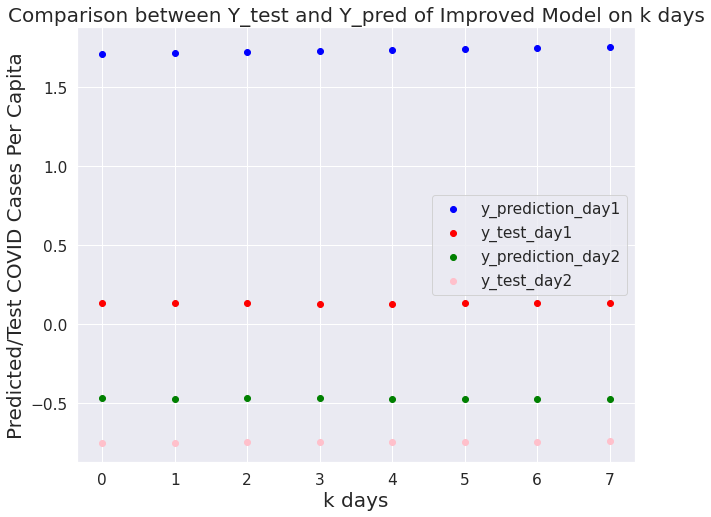

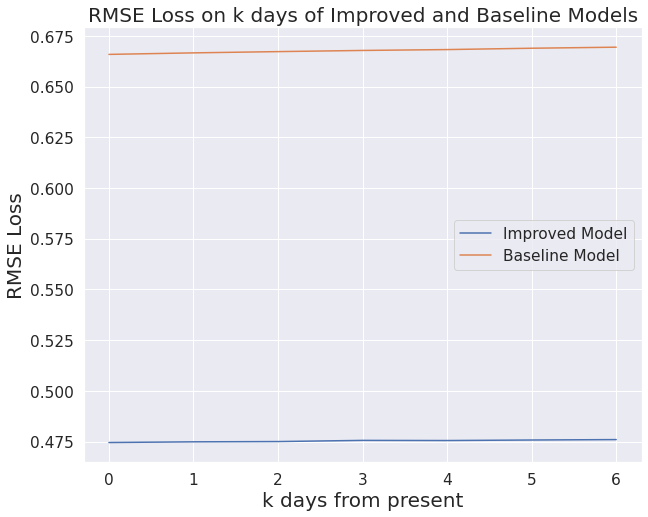

In [103]:
# features_improve = fall6h.loc[:, 'retail_and_recreation_percent_change_from_baseline':]
# def rmse_loss6f(predict, y):
#     return np.sqrt(sum((predict.reset_index(drop=True) - y.reset_index(drop=True)) ** 2) / y.shape[0])
# fe_improve = features_improve.copy()
# fe_improve = fe_improve[np.isfinite(fe_improve).all(1)]
# linear_model_improve = LinearRegression(normalize=True)

# fe_remove = fe_improve.copy()
# features_columns = list(features_improve.loc[:, 'retail_and_recreation_percent_change_from_baseline': 'prior_7_days_residential'].columns.values)
# for i in features_columns:
#     fe_remove = remove_outlier(fe_remove, i, 3)
# X = fe_remove.loc[:,:'weekday'].drop(columns=['NEVER', 'RARELY',
#        'SOMETIMES', 'FREQUENTLY', 'ALWAYS','cases', 'deaths', 'Population',\
#         'prior_1_days_cases', 'prior_2_days_cases', 'prior_3_days_cases',
#        'prior_4_days_cases', 'prior_5_days_cases', 'prior_6_days_cases',
#        'prior_7_days_cases'])
# y = fe_remove.loc[:,'days_0':'days_7']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# linear_model_improve.fit(X_train, y_train)
# plt.figure(figsize=(10, 8))
# y_pred = linear_model_improve.predict(X_test)
# y_pred = pd.DataFrame(y_pred)
# plt.scatter(np.arange(len(y_pred.iloc[0,:])), y_pred.iloc[0,:], color = 'blue',label = 'y_prediction_day1')
# plt.scatter(np.arange(len(y_test.iloc[0,:])), y_test.iloc[0,:], color = 'red',label = 'y_test_day1')
# plt.scatter(np.arange(len(y_pred.iloc[1,:])), y_pred.iloc[1,:], color = 'green',label = 'y_prediction_day2')
# plt.scatter(np.arange(len(y_test.iloc[1,:])), y_test.iloc[1,:], color = 'pink',label = 'y_test_day2')
# plt.xlabel("k days", fontsize = 20)
# plt.ylabel("Predicted/Test COVID Cases Per Capita", fontsize = 20)
# plt.title("Comparison between Y_test and Y_pred of Improved Model on k days", fontsize = 20);
# plt.legend()
# plt.savefig('Comparison between Y_test and Y_pred of Improved Model on k days.png')
# plt.show()
# rese_loss6h = []
# r2_scores = []
# for i in range(7):
    
#     loss = rmse_loss6f(y_pred.iloc[:,i], y_test.iloc[:,i])
#     r2 = r2_score(y_pred.iloc[:,i], y_test.iloc[:,i])
#     rese_loss6h.append(loss)
#     r2_scores.append(r2)
    
# plt.figure(figsize=(10, 8))
# plt.plot(np.arange(len(rese_loss6h)), rese_loss6h, label = 'Improved Model' )
# plt.plot(np.arange(len(rese_loss)), rese_loss, label = 'Baseline Model' )
# plt.xlabel("k days from present", fontsize = 20)
# plt.ylabel("RMSE Loss", fontsize = 20)
# plt.title("RMSE Loss on k days of Improved and Baseline Models", fontsize = 20);
# plt.legend()
# plt.savefig('RMSE Loss on k days of Improved and Baseline Models.png')
# plt.show()

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [107]:
grader.check_all()

q1a results: All test cases passed!

q1d results: All test cases passed!

q1e results: All test cases passed!

q5b results: All test cases passed!

q5d results: All test cases passed!

q5f results: All test cases passed!

q5g results: All test cases passed!

q5i results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [48]:
# Save your notebook first, then run this cell to export your submission.
grader.export()